# Entraînement de modèles pour la détection de pneumonie (scikit-learn avec et sans PCA)

Ce notebook présente l'implémentation et l'entraînement de différents modèles pour la détection de pneumonie à partir de radiographies thoraciques, en utilisant scikit-learn avec et sans réduction de dimensionnalité PCA.

Nous suivrons une approche progressive :
1. Préparation des données avec la bonne répartition train/validation (75%/25%)
2. Pour chaque modèle (Régression Logistique, Arbre de Décision, Random Forest):
   - Entraînement sans PCA
   - Entraînement avec PCA (10, 20, 50, 100, 1000 composantes)
3. Pour SVM (en raison du temps de calcul):
   - Entraînement uniquement avec PCA (10, 20, 50, 100, 1000 composantes)
4. Comparaison des performances de toutes les configurations
5. Sélection et évaluation du meilleur modèle

In [1]:
# Ajouter le répertoire parent au chemin de recherche Python
import sys
import os

# Obtenir le chemin absolu du répertoire parent
notebook_dir = os.path.abspath('')
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
# Imports standard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# Imports scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Imports depuis notre projet
from src.preprocessing import preprocess_images as preproc
from src.visualization import visualizer as viz

# Configuration pour afficher les images dans le notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('ggplot')

## 1. Préparation des données

Nous allons utiliser notre module de prétraitement pour préparer les données avec une répartition train/validation de 75%/25%.

In [3]:
# Définir les chemins vers les données
data_dir = '../data/chest_Xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Définir la taille des images
img_size = (150, 150)

In [4]:
# Préparer les données avec notre module de prétraitement
X_train, y_train, X_val, y_val, X_test, y_test = preproc.preparer_donnees_pour_modele(
    train_dir, test_dir, img_size=img_size, validation_size=0.25
)

Données d'entraînement chargées: 5216 images
  - Images normales: 1341
  - Images avec pneumonie: 3875

Répartition après division:
Ensemble d'entraînement: 3912 images
  - Images normales: 1006
  - Images avec pneumonie: 2906
Ensemble de validation: 1304 images
  - Images normales: 335
  - Images avec pneumonie: 969

Ensemble de test: 624 images
  - Images normales: 234
  - Images avec pneumonie: 390


## 2. Redimensionner les données pour les modèles classiques

Les modèles classiques de scikit-learn attendent des données sous forme de vecteurs 1D, pas des images 2D/3D. Nous devons donc redimensionner nos données.

In [5]:
# Redimensionner les données pour les modèles classiques
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

# Calculer le nombre de caractéristiques
n_features = np.prod(X_train.shape[1:])

# Redimensionner les données
X_train_reshaped = X_train.reshape(n_train, n_features)
X_val_reshaped = X_val.reshape(n_val, n_features)
X_test_reshaped = X_test.reshape(n_test, n_features)

print(f"Forme des données redimensionnées pour les modèles classiques:")
print(f"X_train: {X_train_reshaped.shape}")
print(f"X_val: {X_val_reshaped.shape}")
print(f"X_test: {X_test_reshaped.shape}")

Forme des données redimensionnées pour les modèles classiques:
X_train: (3912, 22500)
X_val: (1304, 22500)
X_test: (624, 22500)


In [6]:
def evaluer_modele(y_true, y_pred, y_proba=None):
    """
    Évalue les performances d'un modèle et retourne les métriques.
    
    Args:
        y_true: Les vraies étiquettes
        y_pred: Les prédictions du modèle
        y_proba: Les probabilités prédites (pour ROC AUC)
        
    Returns:
        Un dictionnaire contenant les métriques d'évaluation
    """
    resultats = {}
    
    # Métriques de base
    resultats['accuracy'] = accuracy_score(y_true, y_pred)
    resultats['precision'] = precision_score(y_true, y_pred)
    resultats['recall'] = recall_score(y_true, y_pred)
    resultats['f1'] = f1_score(y_true, y_pred)
    
    # Matrice de confusion
    resultats['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    
    # ROC AUC si les probabilités sont fournies
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        resultats['roc_auc'] = auc(fpr, tpr)
        resultats['fpr'] = fpr
        resultats['tpr'] = tpr
    
    return resultats

## 3. Entraînement des modèles avec et sans PCA

Nous allons maintenant entraîner chaque modèle dans différentes configurations:
- Sans PCA (données originales) - sauf pour SVM
- Avec PCA à 10 composantes
- Avec PCA à 20 composantes
- Avec PCA à 50 composantes
- Avec PCA à 100 composantes
- Avec PCA à 1000 composantes

In [7]:
# Définition des modèles à tester
models = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear'],
            'penalty': ['l2']
        },
        'skip_no_pca': False  # Ne pas sauter l'entraînement sans PCA
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'criterion': ['gini']
        },
        'skip_no_pca': False  # Ne pas sauter l'entraînement sans PCA
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'min_samples_split': [2]
        },
        'skip_no_pca': False  # Ne pas sauter l'entraînement sans PCA
    },
    {
        'name': 'SVM',
        'model': SVC(probability=True, random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
            'gamma': ['scale'],
            'kernel': ['rbf']
        },
        'skip_no_pca': False  # Ne pas sauter l'entraînement sans PCA
    }
]

# Configurations PCA à tester
pca_components = [10, 20, 50, 100, 1000]

# Dictionnaire pour stocker tous les résultats
all_results = {}

In [8]:
# Dictionnaire pour stocker tous les résultats
all_results = {}

# Définir les métriques de scoring à tester
scoring_metrics = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']

# Pour chaque métrique de scoring
for scoring_metric in scoring_metrics:
    print(f"\n{'*'*80}")
    print(f"MÉTRIQUE DE SCORING: {scoring_metric.upper()}")
    print(f"{'*'*80}")
    
    # Dictionnaire pour stocker les résultats de cette métrique
    scoring_results = {}
    
    # Entraînement de tous les modèles avec cette métrique
    for model_info in models:
        model_name = model_info['name']
        print(f"\n{'='*70}")
        print(f"Modèle: {model_name}")
        print(f"{'='*70}")
        
        # Dictionnaire pour stocker les résultats de ce modèle
        model_results = {}
        
        # Entraînement sans PCA (sauf pour SVM)
        if not model_info['skip_no_pca']:
            print(f"\n{'-'*50}")
            print(f"Configuration: Sans PCA")
            print(f"{'-'*50}")
            
            # Créer une instance de GridSearchCV avec la métrique actuelle
            grid_search = GridSearchCV(
                estimator=model_info['model'],
                param_grid=model_info['param_grid'],
                cv=3,
                scoring=scoring_metric,  # Utiliser la métrique actuelle
                n_jobs=-1,
                verbose=1
            )
            
            # Mesurer le temps d'entraînement
            start_time = time.time()
            
            # Entraîner le modèle
            grid_search.fit(X_train_reshaped, y_train)
            
            # Calculer le temps d'entraînement
            training_time = time.time() - start_time
            
            # Meilleurs paramètres et score
            print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
            print(f"Meilleur score de validation croisée ({scoring_metric}): {grid_search.best_score_:.4f}")
            print(f"Temps d'entraînement: {training_time:.2f} secondes")
            
            # Prédictions sur l'ensemble de validation
            best_model = grid_search.best_estimator_
            y_val_pred = best_model.predict(X_val_reshaped)
            y_val_proba = best_model.predict_proba(X_val_reshaped)[:, 1]
            
            # Évaluation du modèle
            resultats = evaluer_modele(y_val, y_val_pred, y_val_proba)
            
            # Afficher les résultats
            print("\nPerformances sur l'ensemble de validation:")
            print(f"Accuracy: {resultats['accuracy']:.4f}")
            print(f"Precision: {resultats['precision']:.4f}")
            print(f"Recall: {resultats['recall']:.4f}")
            print(f"F1-score: {resultats['f1']:.4f}")
            print(f"ROC AUC: {resultats['roc_auc']:.4f}")
            
            # Stocker les résultats
            model_results['Sans PCA'] = {
                'best_model': best_model,
                'best_params': grid_search.best_params_,
                'training_time': training_time,
                'resultats': resultats
            }
        
        # Entraînement avec différentes configurations PCA
        for n_comp in pca_components:
            # Vérifier si le nombre de composantes est valide
            if n_comp > min(X_train_reshaped.shape[0], X_train_reshaped.shape[1]):
                print(f"\nSkipping PCA with {n_comp} components (too many for the dataset)")
                continue
                
            print(f"\n{'-'*50}")
            print(f"Configuration: PCA avec {n_comp} composantes")
            print(f"{'-'*50}")
            
            # Appliquer PCA
            pca = PCA(n_components=n_comp, random_state=42)
            X_train_pca = pca.fit_transform(X_train_reshaped)
            X_val_pca = pca.transform(X_val_reshaped)
            
            # Variance expliquée
            variance_explained = np.sum(pca.explained_variance_ratio_)
            print(f"Variance expliquée: {variance_explained:.4f}")
            
            # Créer une instance de GridSearchCV avec la métrique actuelle
            grid_search = GridSearchCV(
                estimator=model_info['model'],
                param_grid=model_info['param_grid'],
                cv=3,
                scoring=scoring_metric,  # Utiliser la métrique actuelle
                n_jobs=-1,
                verbose=1
            )
            
            # Mesurer le temps d'entraînement
            start_time = time.time()
            
            # Entraîner le modèle
            grid_search.fit(X_train_pca, y_train)
            
            # Calculer le temps d'entraînement
            training_time = time.time() - start_time
            
            # Meilleurs paramètres et score
            print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
            print(f"Meilleur score de validation croisée ({scoring_metric}): {grid_search.best_score_:.4f}")
            print(f"Temps d'entraînement: {training_time:.2f} secondes")
            
            # Prédictions sur l'ensemble de validation
            best_model = grid_search.best_estimator_
            y_val_pred = best_model.predict(X_val_pca)
            y_val_proba = best_model.predict_proba(X_val_pca)[:, 1]
            
            # Évaluation du modèle
            resultats = evaluer_modele(y_val, y_val_pred, y_val_proba)
            
            # Afficher les résultats
            print("\nPerformances sur l'ensemble de validation:")
            print(f"Accuracy: {resultats['accuracy']:.4f}")
            print(f"Precision: {resultats['precision']:.4f}")
            print(f"Recall: {resultats['recall']:.4f}")
            print(f"F1-score: {resultats['f1']:.4f}")
            print(f"ROC AUC: {resultats['roc_auc']:.4f}")
            
            # Stocker les résultats
            model_results[f'PCA-{n_comp}'] = {
                'best_model': best_model,
                'best_params': grid_search.best_params_,
                'pca': pca,
                'training_time': training_time,
                'resultats': resultats,
                'variance_explained': variance_explained
            }
        
        # Stocker les résultats de ce modèle
        scoring_results[model_name] = model_results
    
    # Stocker les résultats de cette métrique de scoring
    all_results[scoring_metric] = scoring_results


********************************************************************************
MÉTRIQUE DE SCORING: ACCURACY
********************************************************************************

Modèle: Logistic Regression

--------------------------------------------------
Configuration: Sans PCA
--------------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Meilleurs paramètres: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score de validation croisée (accuracy): 0.9594
Temps d'entraînement: 63.73 secondes

Performances sur l'ensemble de validation:
Accuracy: 0.9655
Precision: 0.9823
Recall: 0.9711
F1-score: 0.9766
ROC AUC: 0.9916

--------------------------------------------------
Configuration: PCA avec 10 composantes
--------------------------------------------------
Variance expliquée: 0.6456
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Meilleurs paramètres: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'

## 4. Comparaison des résultats

Nous allons maintenant comparer les performances des différents modèles avec et sans PCA.


********************************************************************************
RÉSULTATS POUR LA MÉTRIQUE DE SCORING: ACCURACY
********************************************************************************

Comparaison des configurations pour Logistic Regression (Scoring: accuracy)


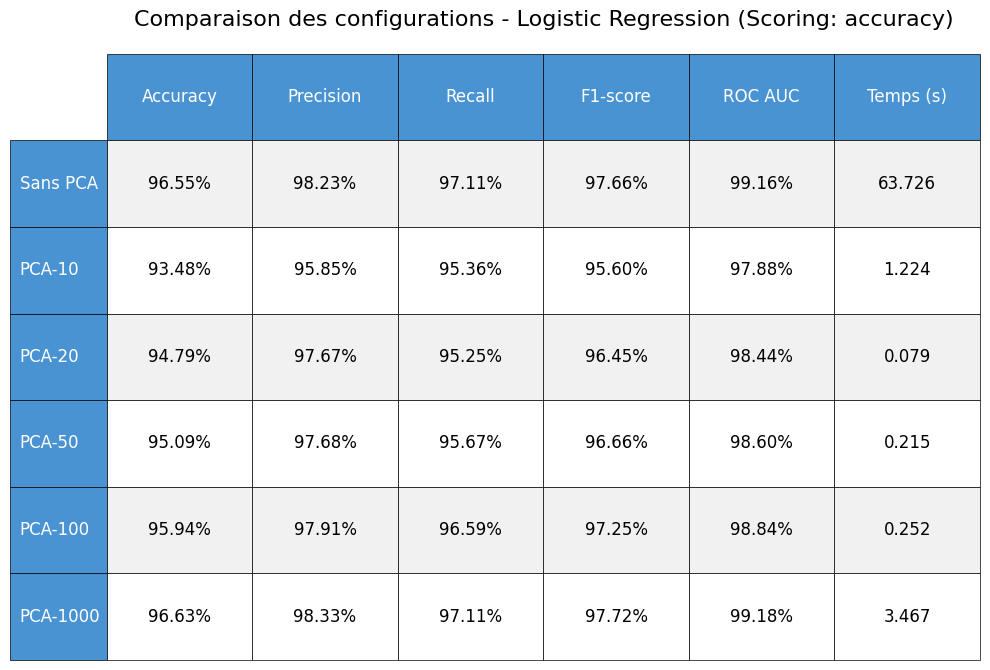


Comparaison des configurations pour Decision Tree (Scoring: accuracy)


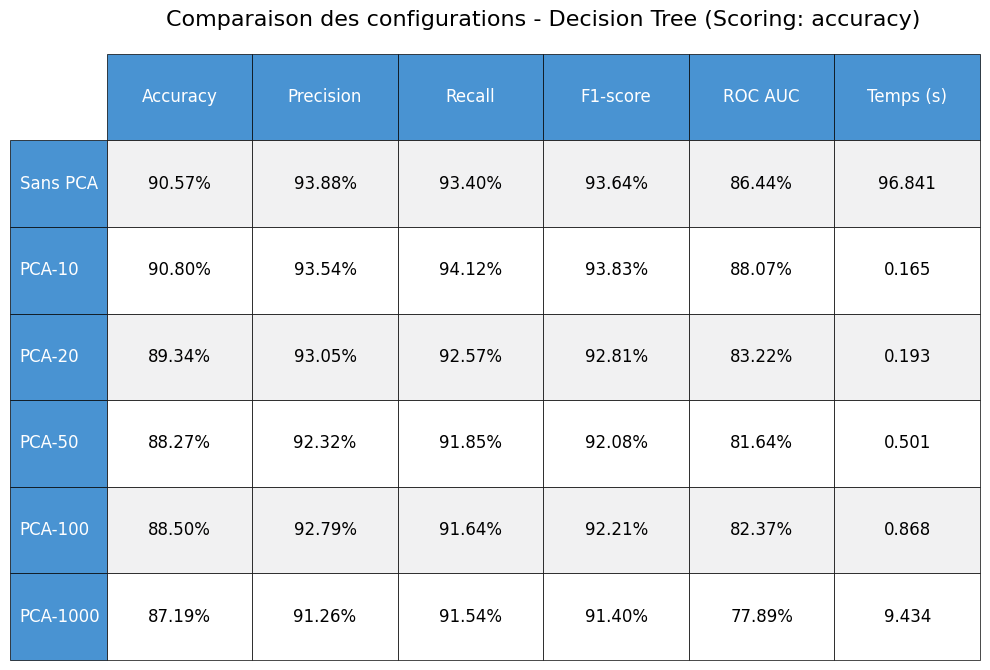


Comparaison des configurations pour Random Forest (Scoring: accuracy)


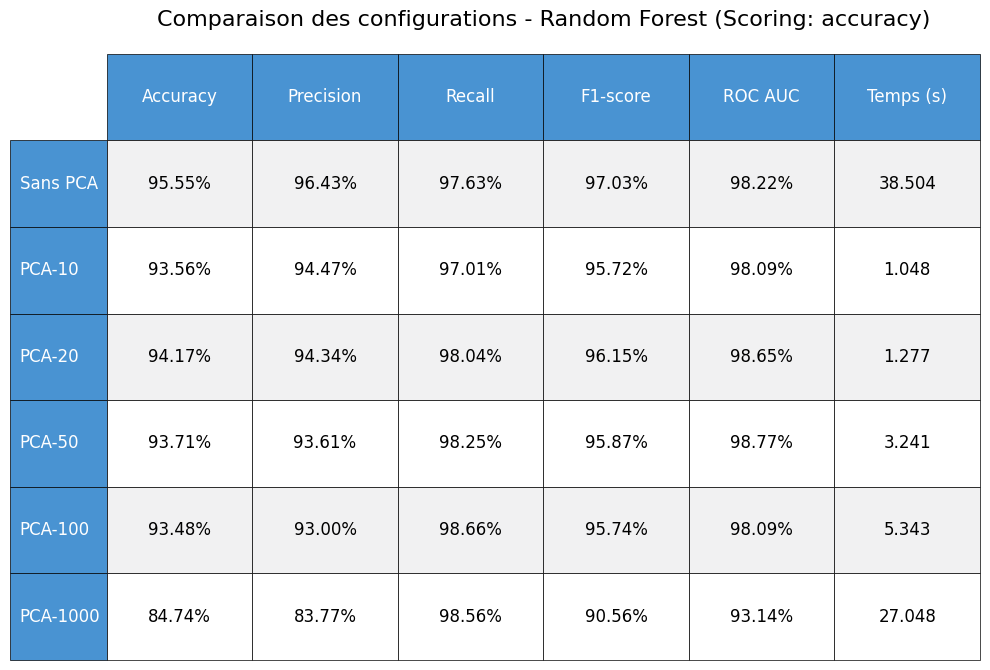


Comparaison des configurations pour SVM (Scoring: accuracy)


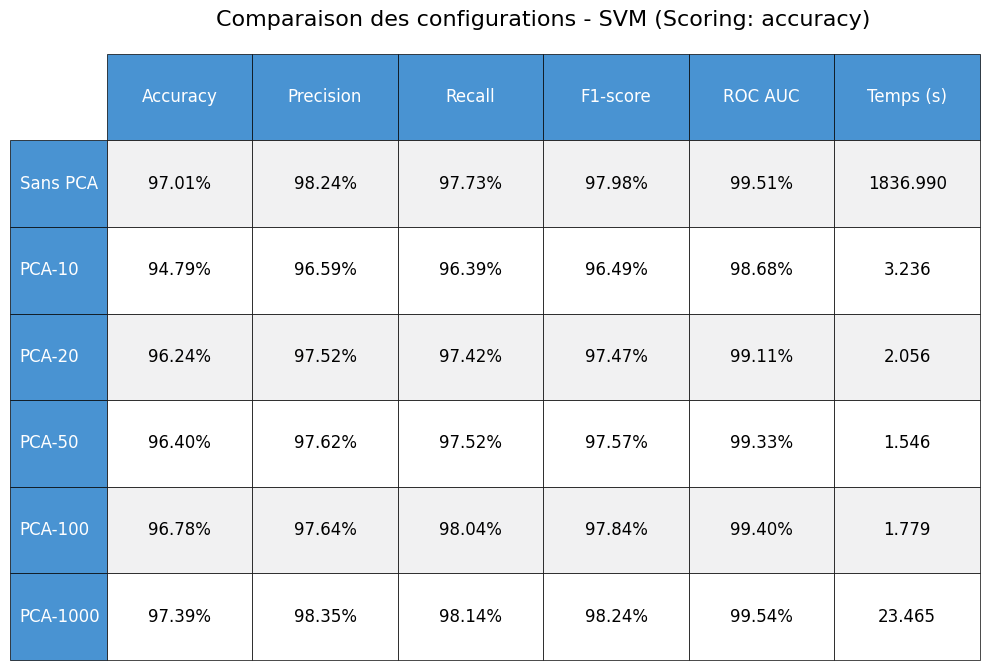


********************************************************************************
RÉSULTATS POUR LA MÉTRIQUE DE SCORING: F1
********************************************************************************

Comparaison des configurations pour Logistic Regression (Scoring: f1)


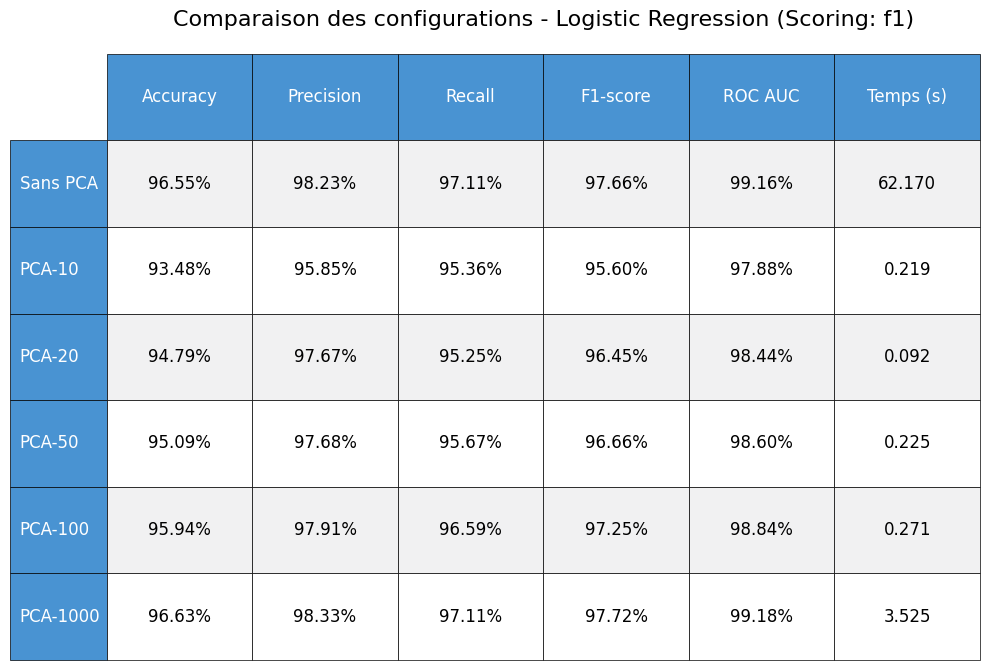


Comparaison des configurations pour Decision Tree (Scoring: f1)


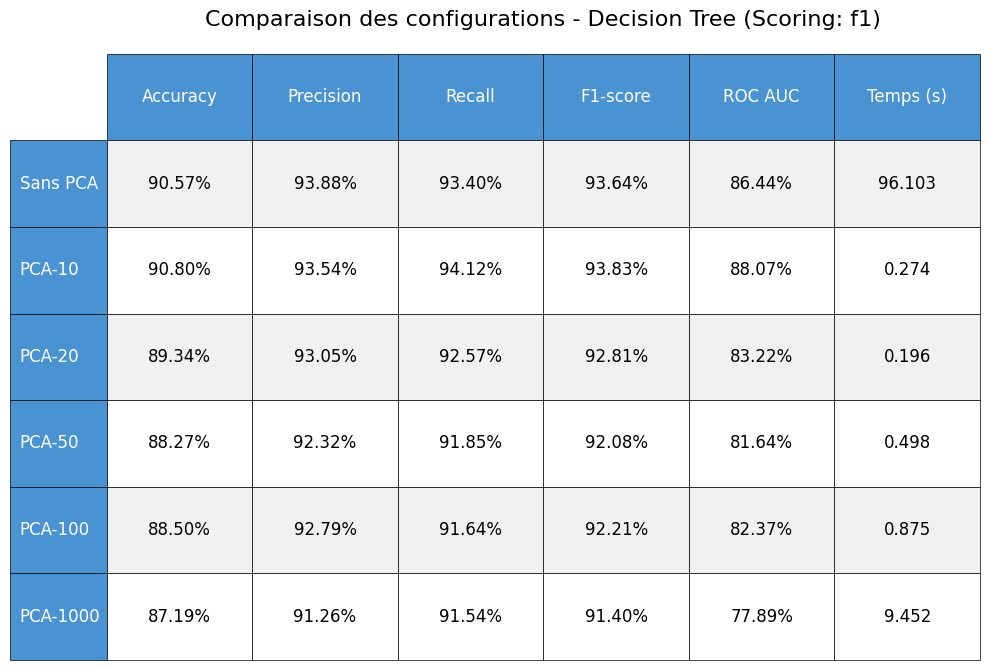


Comparaison des configurations pour Random Forest (Scoring: f1)


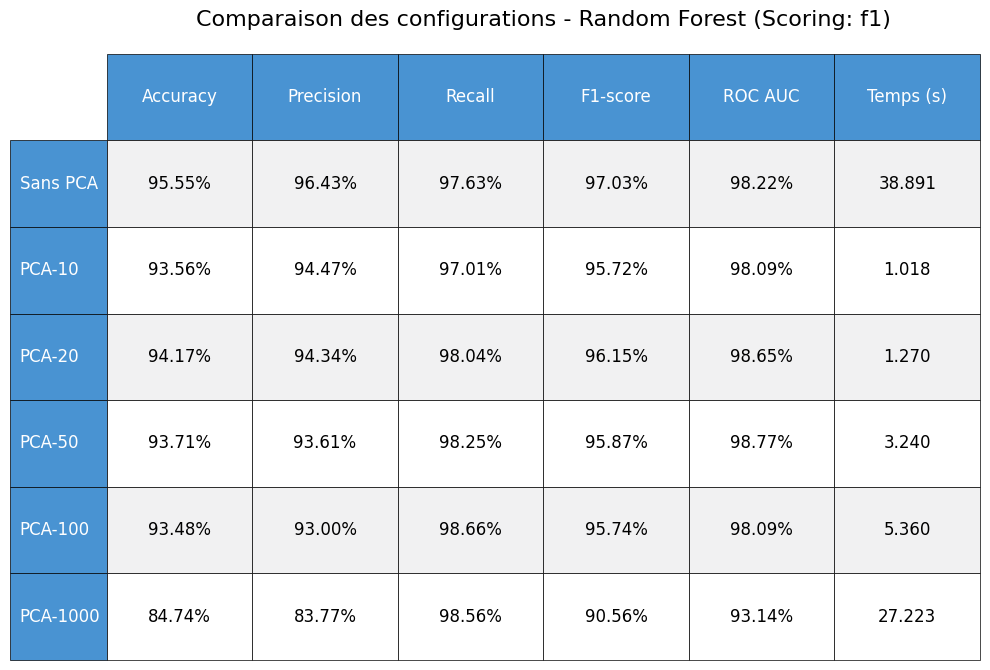


Comparaison des configurations pour SVM (Scoring: f1)


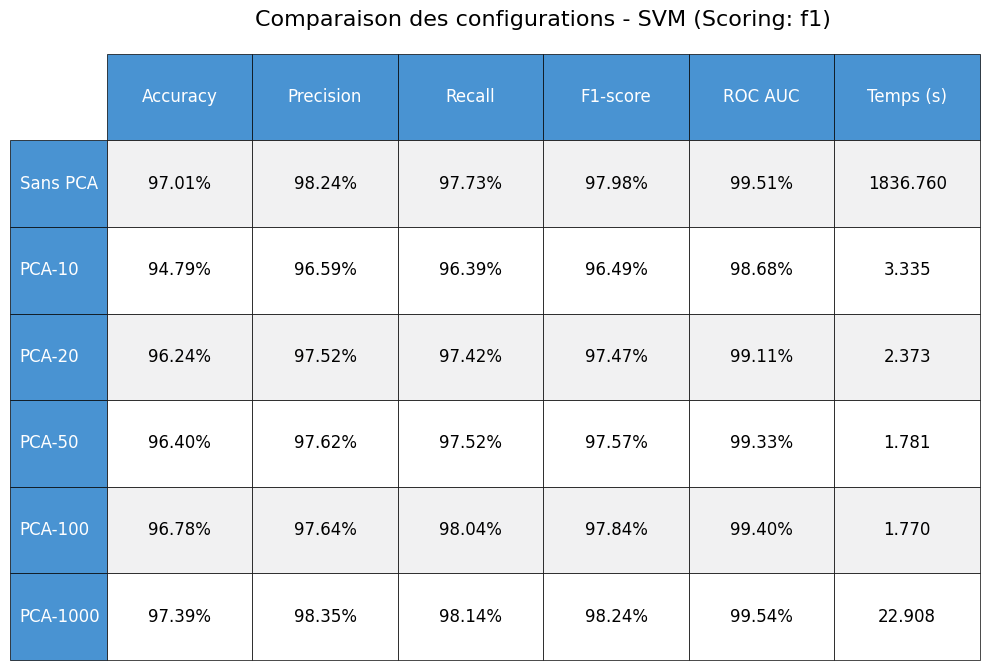


********************************************************************************
RÉSULTATS POUR LA MÉTRIQUE DE SCORING: ROC_AUC
********************************************************************************

Comparaison des configurations pour Logistic Regression (Scoring: roc_auc)


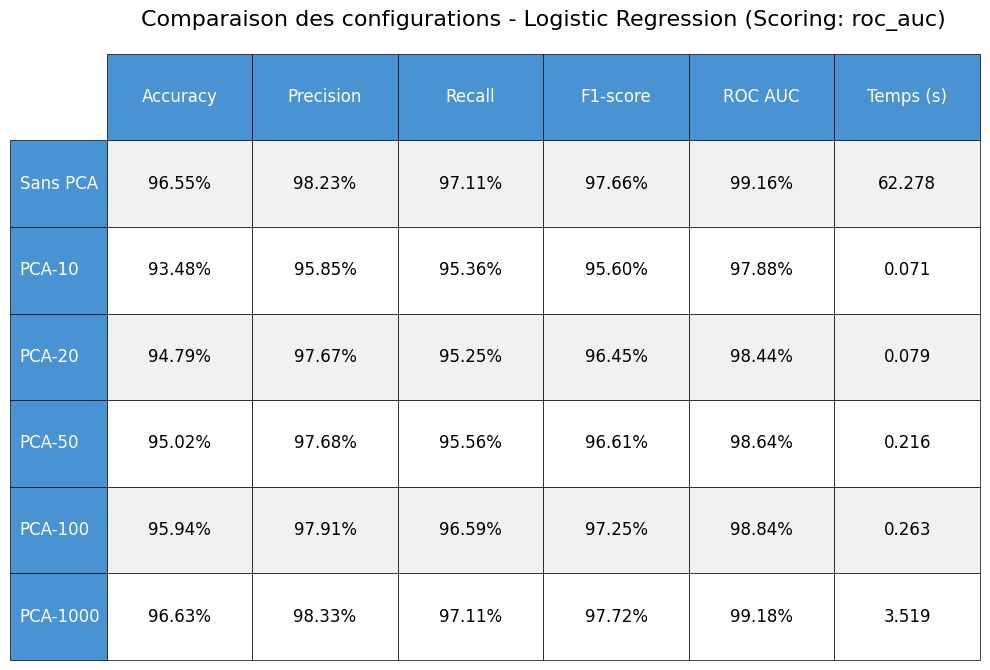


Comparaison des configurations pour Decision Tree (Scoring: roc_auc)


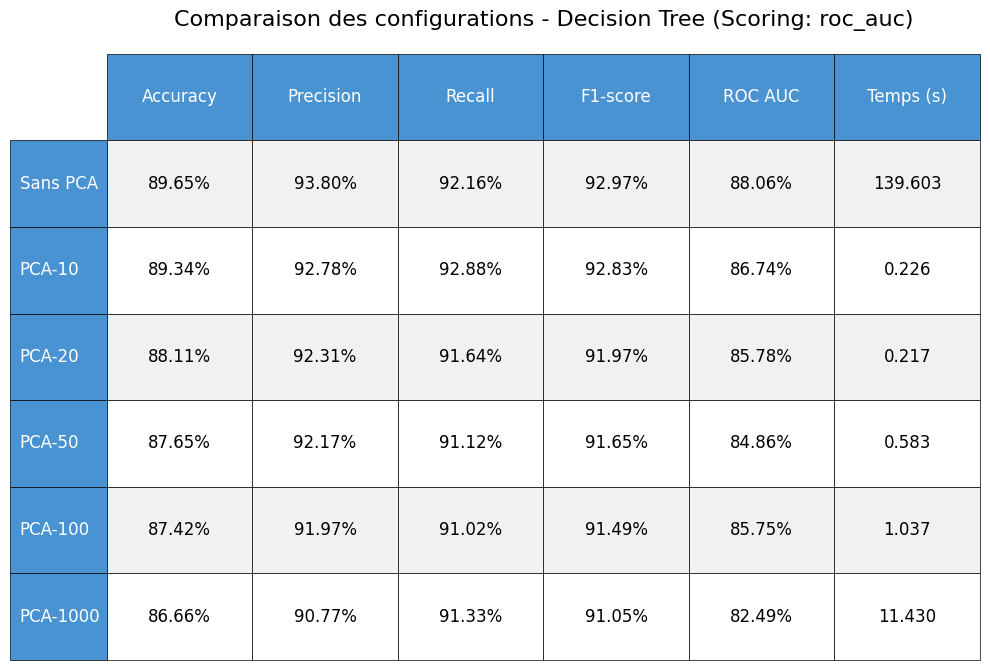


Comparaison des configurations pour Random Forest (Scoring: roc_auc)


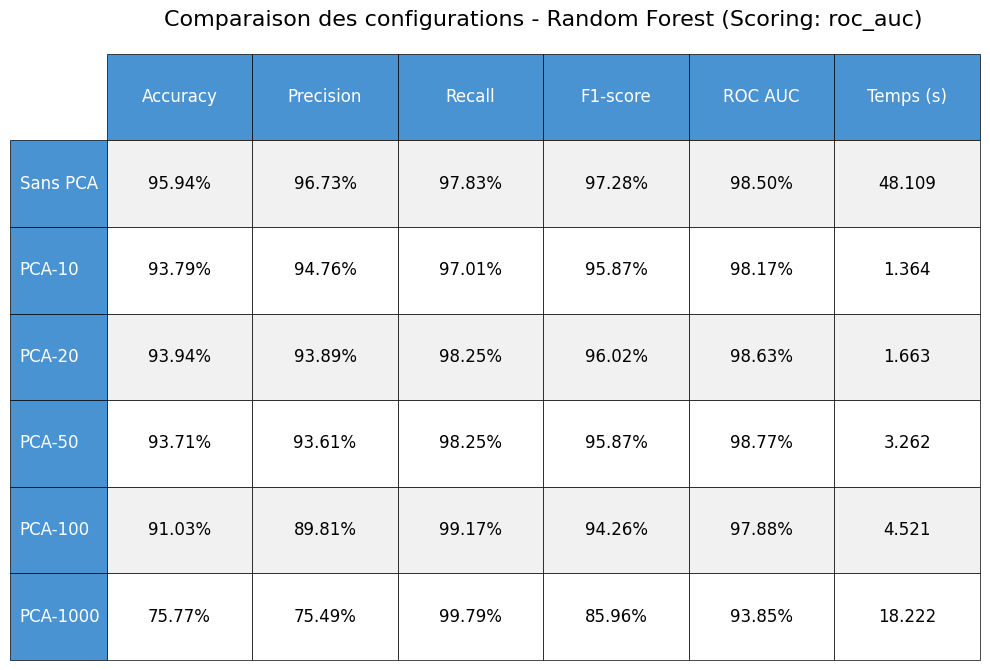


Comparaison des configurations pour SVM (Scoring: roc_auc)


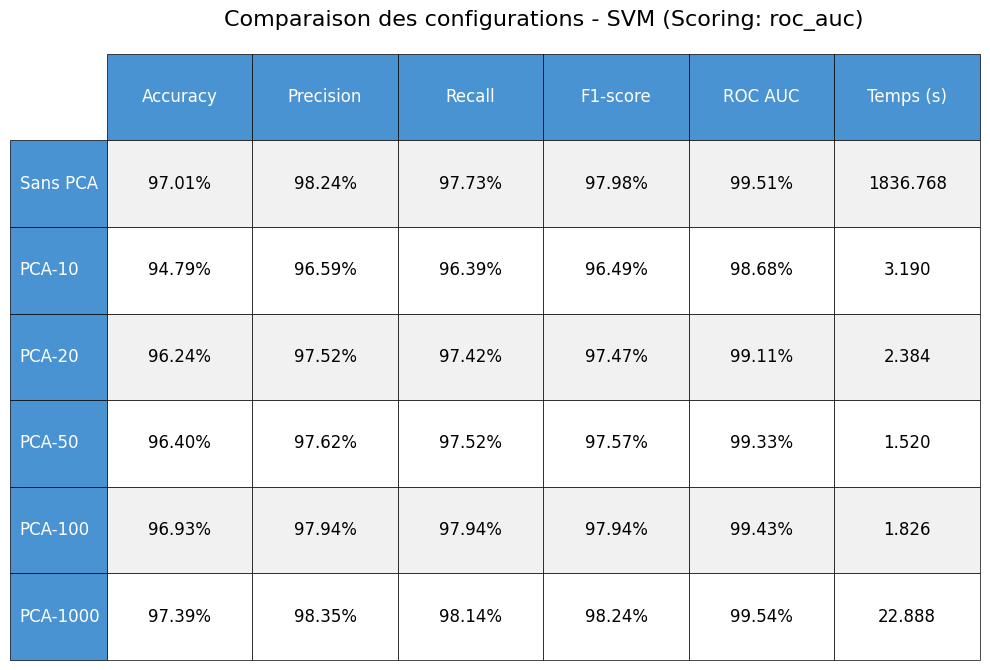


********************************************************************************
RÉSULTATS POUR LA MÉTRIQUE DE SCORING: PRECISION
********************************************************************************

Comparaison des configurations pour Logistic Regression (Scoring: precision)


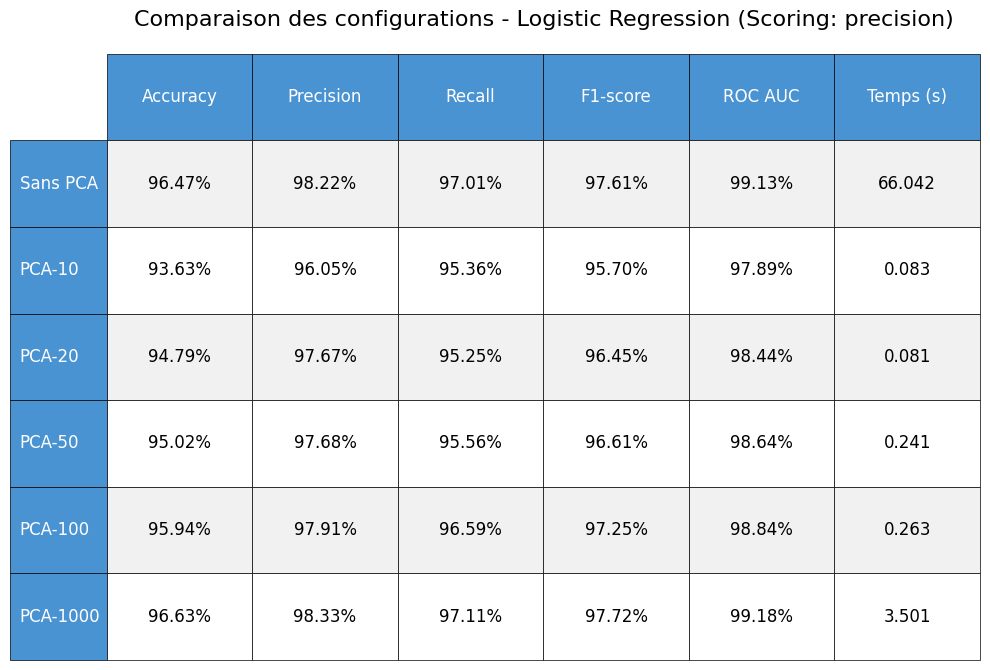


Comparaison des configurations pour Decision Tree (Scoring: precision)


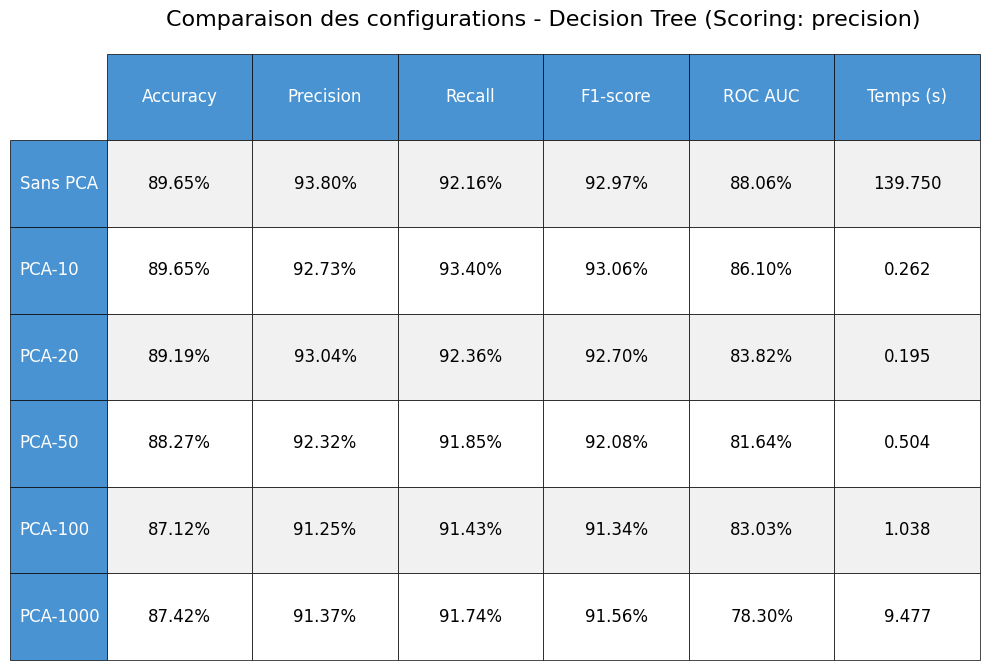


Comparaison des configurations pour Random Forest (Scoring: precision)


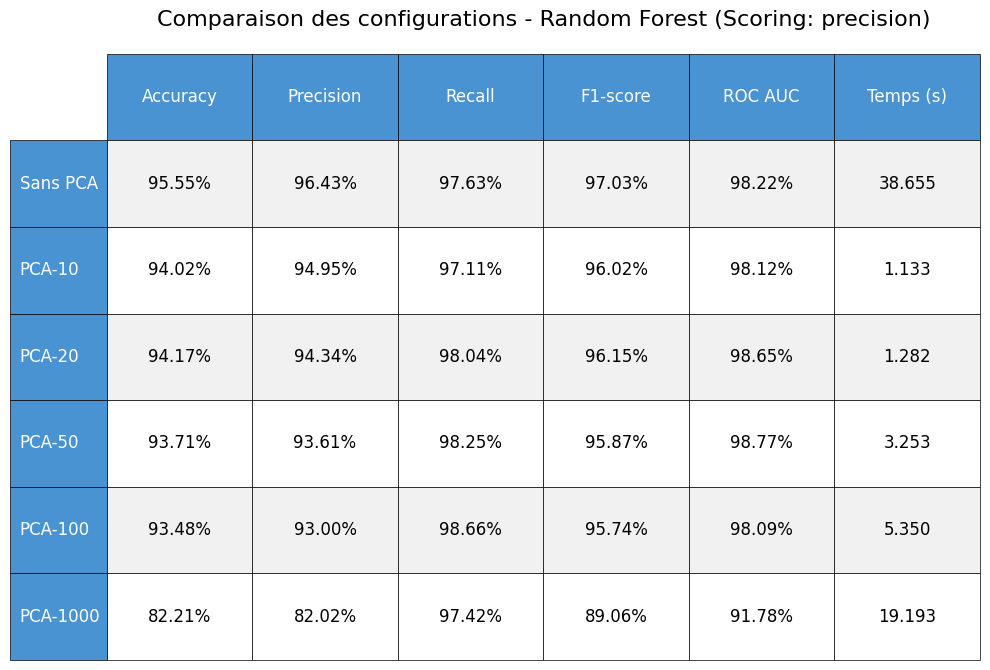


Comparaison des configurations pour SVM (Scoring: precision)


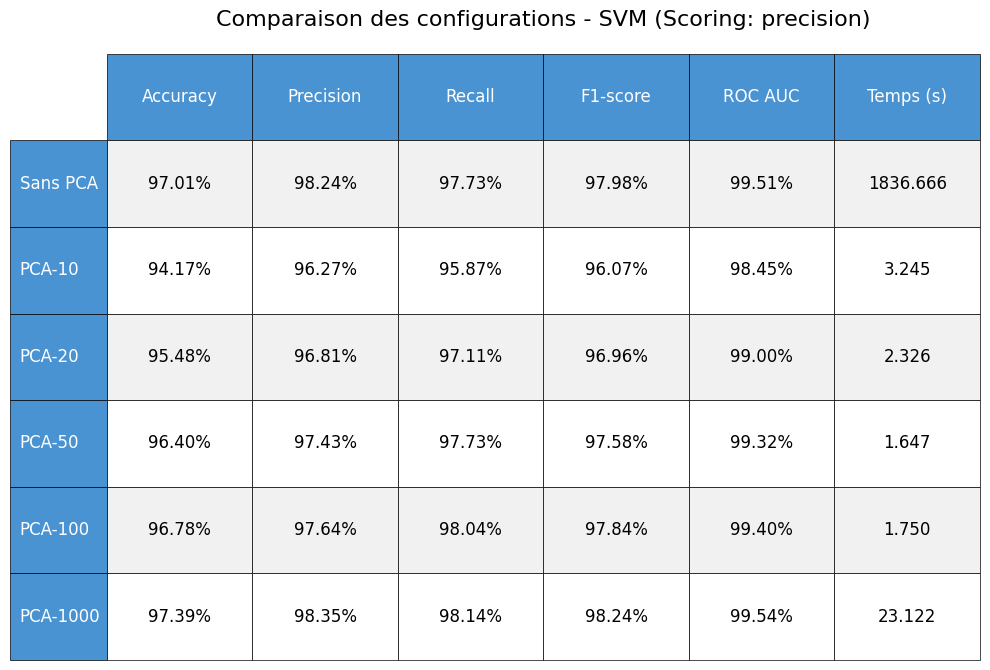


********************************************************************************
RÉSULTATS POUR LA MÉTRIQUE DE SCORING: RECALL
********************************************************************************

Comparaison des configurations pour Logistic Regression (Scoring: recall)


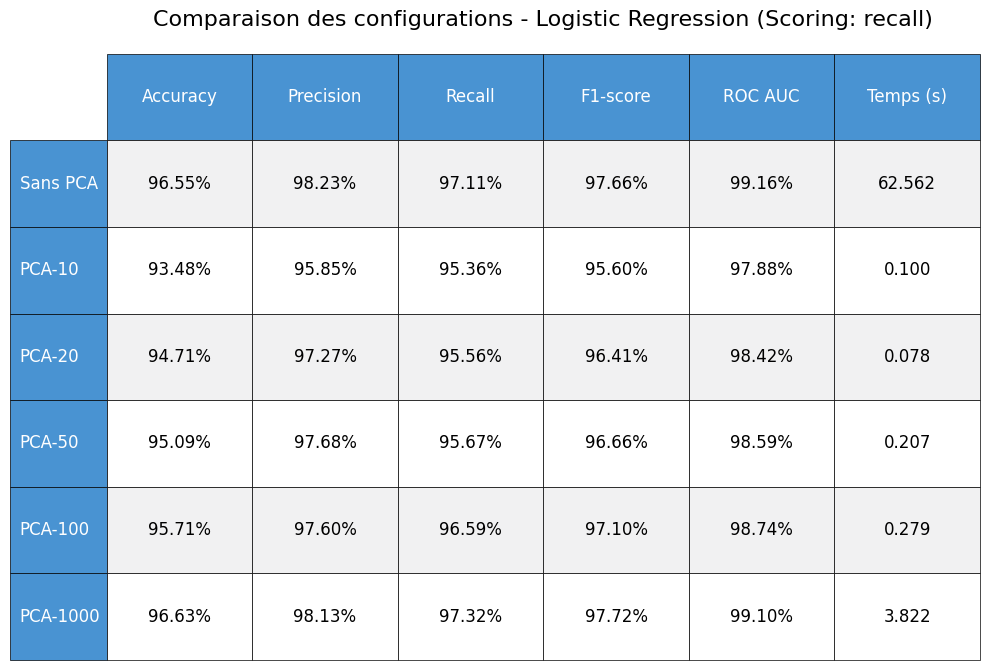


Comparaison des configurations pour Decision Tree (Scoring: recall)


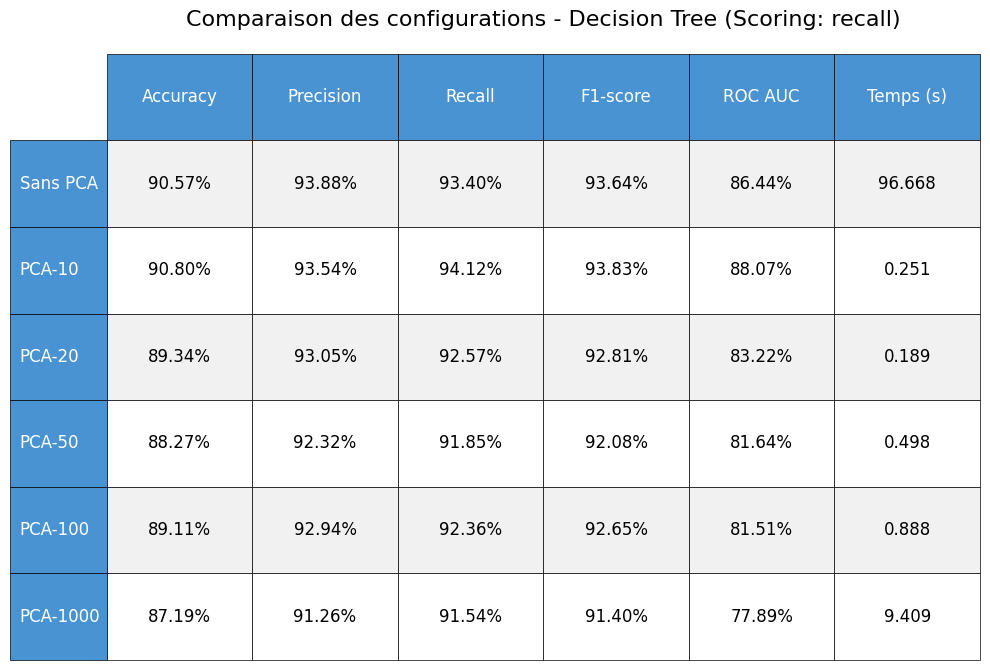


Comparaison des configurations pour Random Forest (Scoring: recall)


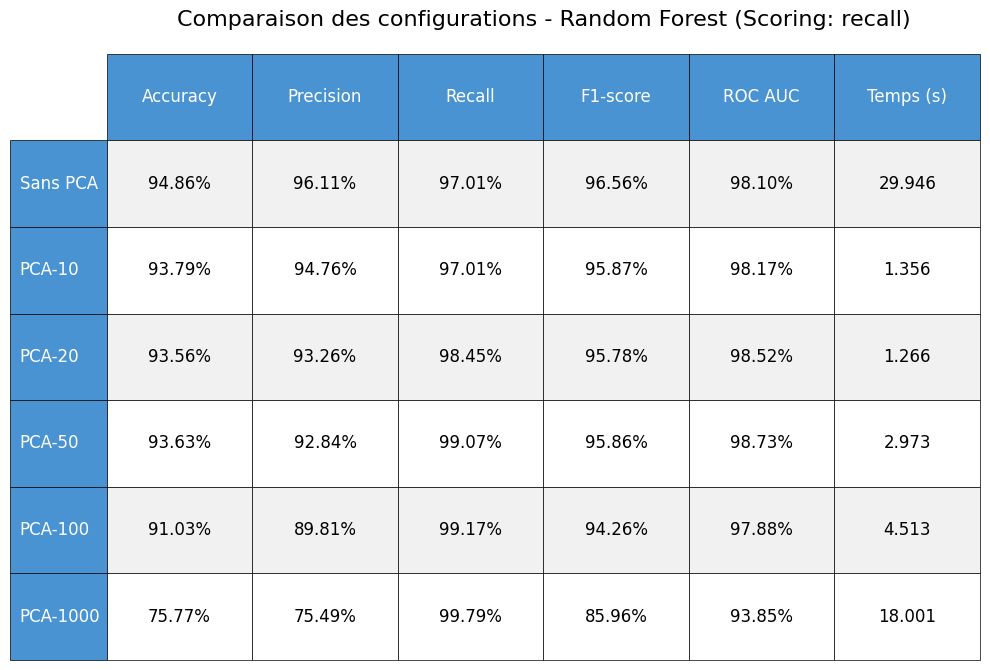


Comparaison des configurations pour SVM (Scoring: recall)


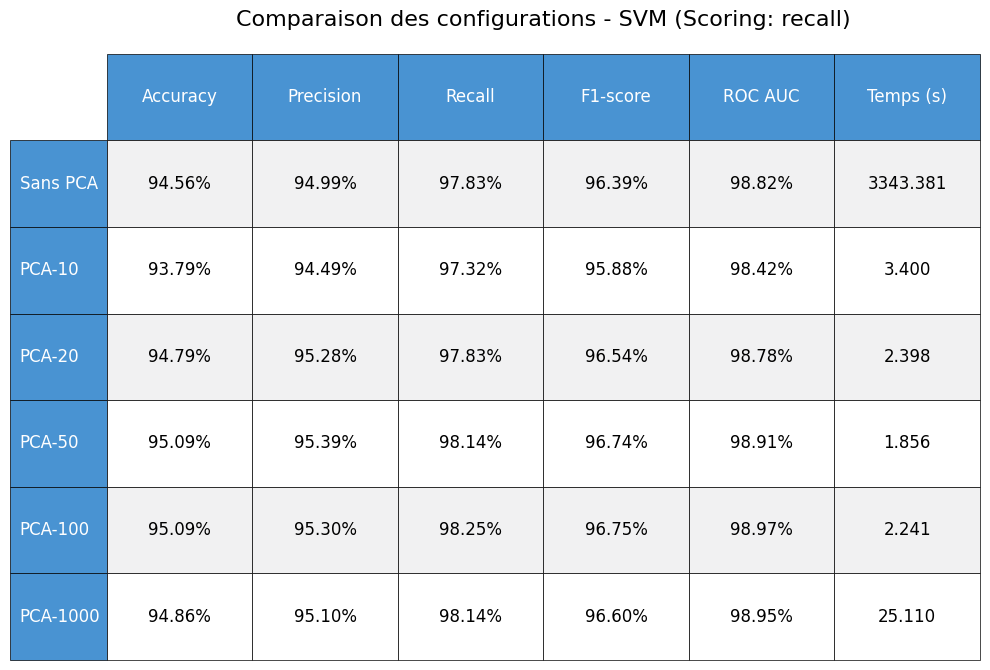

In [9]:
# Pour chaque métrique de scoring
for scoring_metric, scoring_results in all_results.items():
    print(f"\n{'*'*80}")
    print(f"RÉSULTATS POUR LA MÉTRIQUE DE SCORING: {scoring_metric.upper()}")
    print(f"{'*'*80}")
    
    # Pour chaque modèle, créer un tableau comparatif des différentes configurations
    for model_name, model_configs in scoring_results.items():
        print(f"\n{'='*70}")
        print(f"Comparaison des configurations pour {model_name} (Scoring: {scoring_metric})")
        print(f"{'='*70}")
        
        # Préparation des données pour le tableau comparatif
        configs = []
        metriques = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'Temps (s)']
        valeurs = []
            
        for config_name, config_data in model_configs.items():
            configs.append(config_name)
            
            res = config_data['resultats']
            valeurs.append([
                res['accuracy'],
                res['precision'],
                res['recall'],
                res['f1'],
                res['roc_auc'],
                config_data['training_time']
            ])
        
        # Affichage du tableau comparatif
        viz.afficher_tableau_comparatif_modeles(configs, metriques, valeurs, 
                                               titre=f"Comparaison des configurations - {model_name} (Scoring: {scoring_metric})")


********************************************************************************
TABLEAU GLOBAL POUR LA MÉTRIQUE DE SCORING: ACCURACY
********************************************************************************


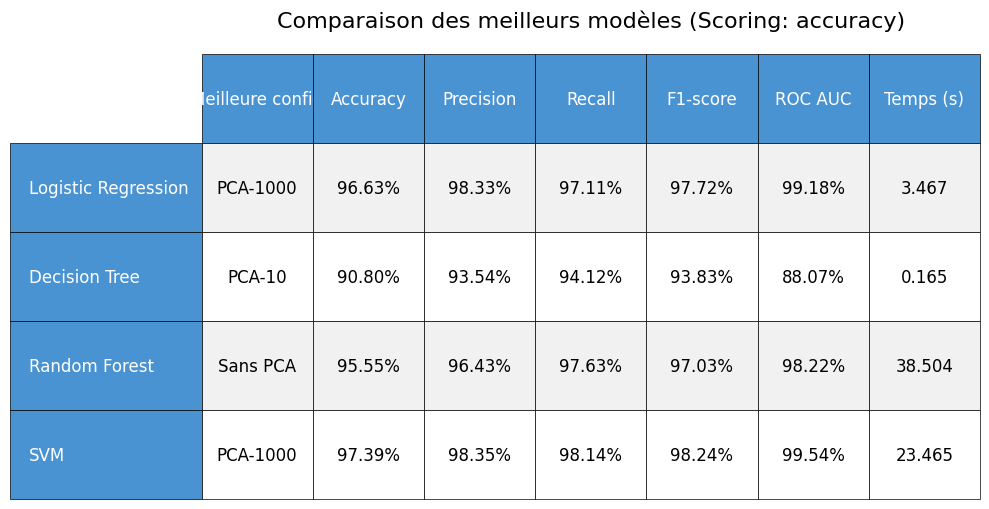


********************************************************************************
TABLEAU GLOBAL POUR LA MÉTRIQUE DE SCORING: F1
********************************************************************************


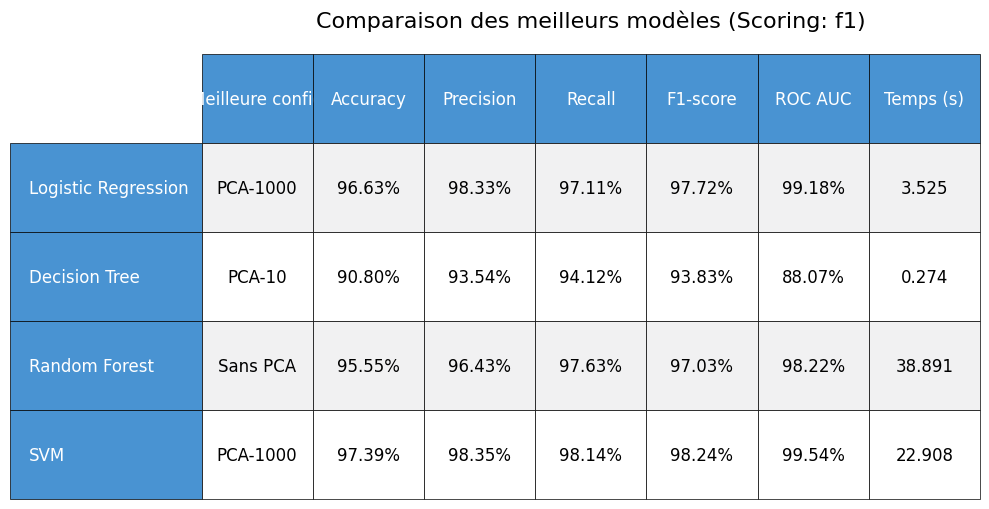


********************************************************************************
TABLEAU GLOBAL POUR LA MÉTRIQUE DE SCORING: ROC_AUC
********************************************************************************


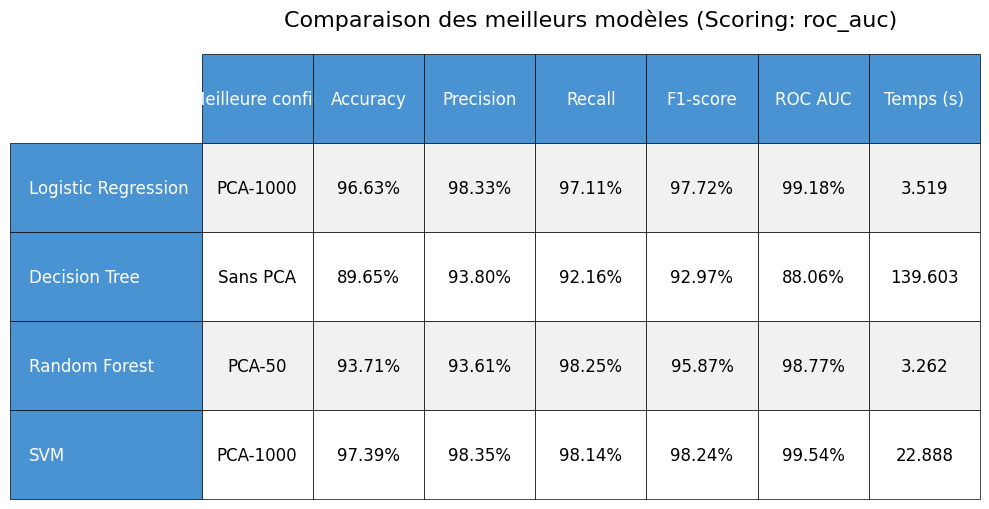


********************************************************************************
TABLEAU GLOBAL POUR LA MÉTRIQUE DE SCORING: PRECISION
********************************************************************************


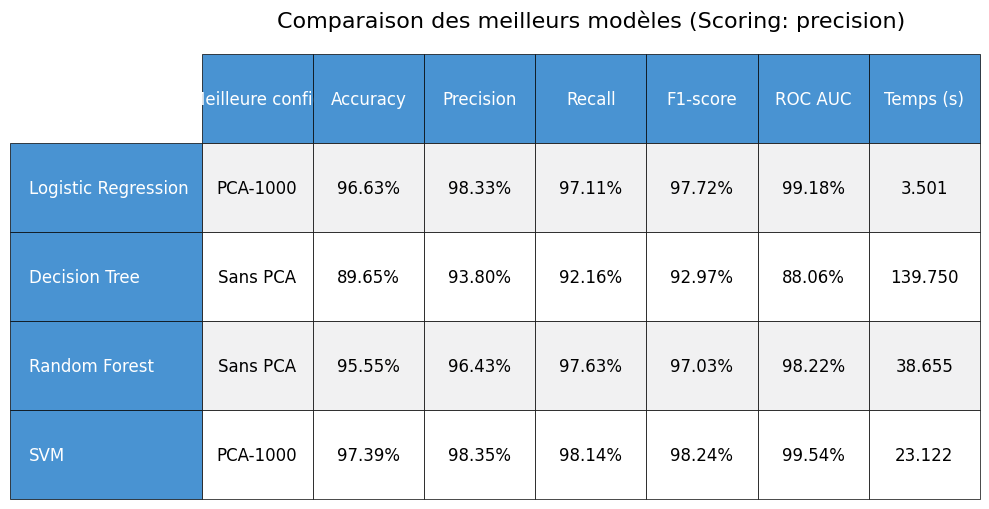


********************************************************************************
TABLEAU GLOBAL POUR LA MÉTRIQUE DE SCORING: RECALL
********************************************************************************


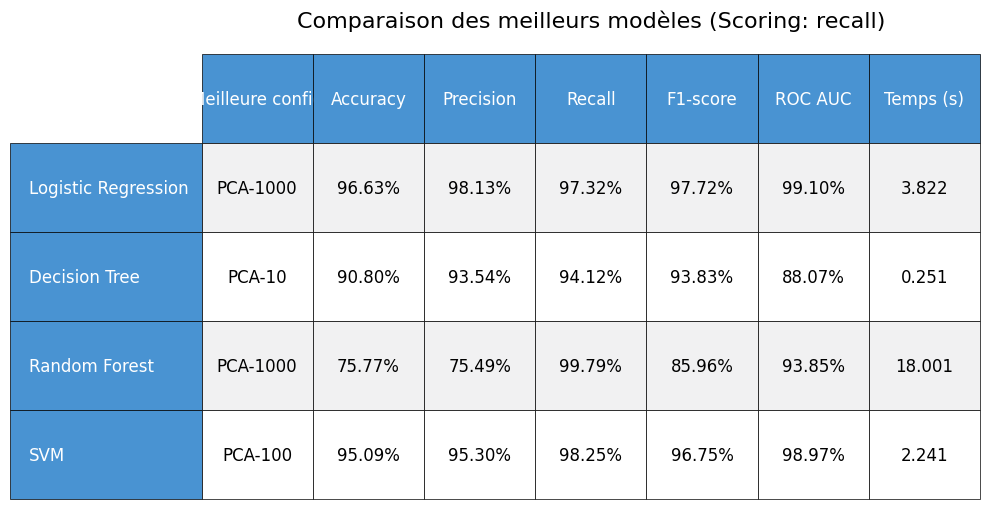

In [10]:
# Pour chaque métrique de scoring, créer un tableau comparatif global
for scoring_metric in scoring_metrics:
    print(f"\n{'*'*80}")
    print(f"TABLEAU GLOBAL POUR LA MÉTRIQUE DE SCORING: {scoring_metric.upper()}")
    print(f"{'*'*80}")
    
    scoring_results = all_results[scoring_metric]
    
    # Préparation des données pour le tableau comparatif global
    # Nous allons comparer la meilleure configuration de chaque modèle
    modeles = []
    metriques = ['Meilleure config', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'Temps (s)']
    valeurs = []
    
    for model_name, model_configs in scoring_results.items():
        modeles.append(model_name)
        
        # Trouver la meilleure configuration (basée sur la métrique de scoring actuelle)
        best_config = None
        best_score = -1
        
        for config_name, config_data in model_configs.items():
            # Utiliser la métrique correspondante pour déterminer la meilleure config
            current_score = config_data['resultats'][scoring_metric] if scoring_metric in config_data['resultats'] else config_data['resultats']['accuracy']
            
            if current_score > best_score:
                best_score = current_score
                best_config = config_name
        
        # Récupérer les données de la meilleure configuration
        best_data = model_configs[best_config]
        res = best_data['resultats']
        
        valeurs.append([
            best_config,
            res['accuracy'],
            res['precision'],
            res['recall'],
            res['f1'],
            res['roc_auc'],
            best_data['training_time']
        ])
    
    # Affichage du tableau comparatif global
    viz.afficher_tableau_comparatif_modeles(modeles, metriques, valeurs, 
                                           titre=f"Comparaison des meilleurs modèles (Scoring: {scoring_metric})")


********************************************************************************
VISUALISATION POUR LA MÉTRIQUE DE SCORING: ACCURACY
********************************************************************************


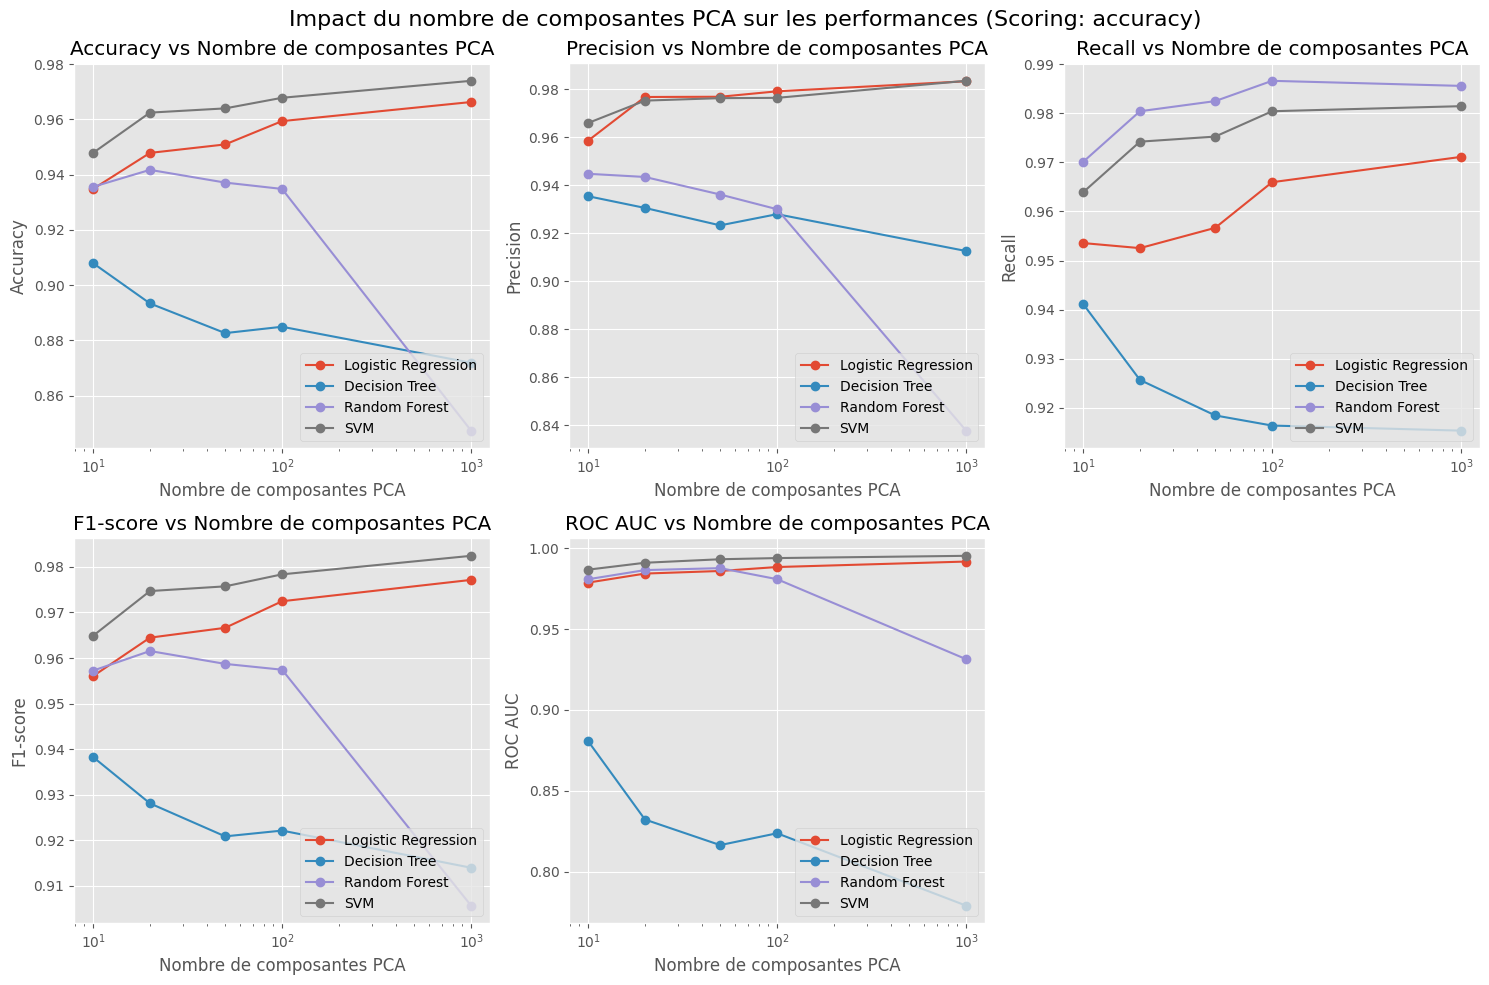


********************************************************************************
VISUALISATION POUR LA MÉTRIQUE DE SCORING: F1
********************************************************************************


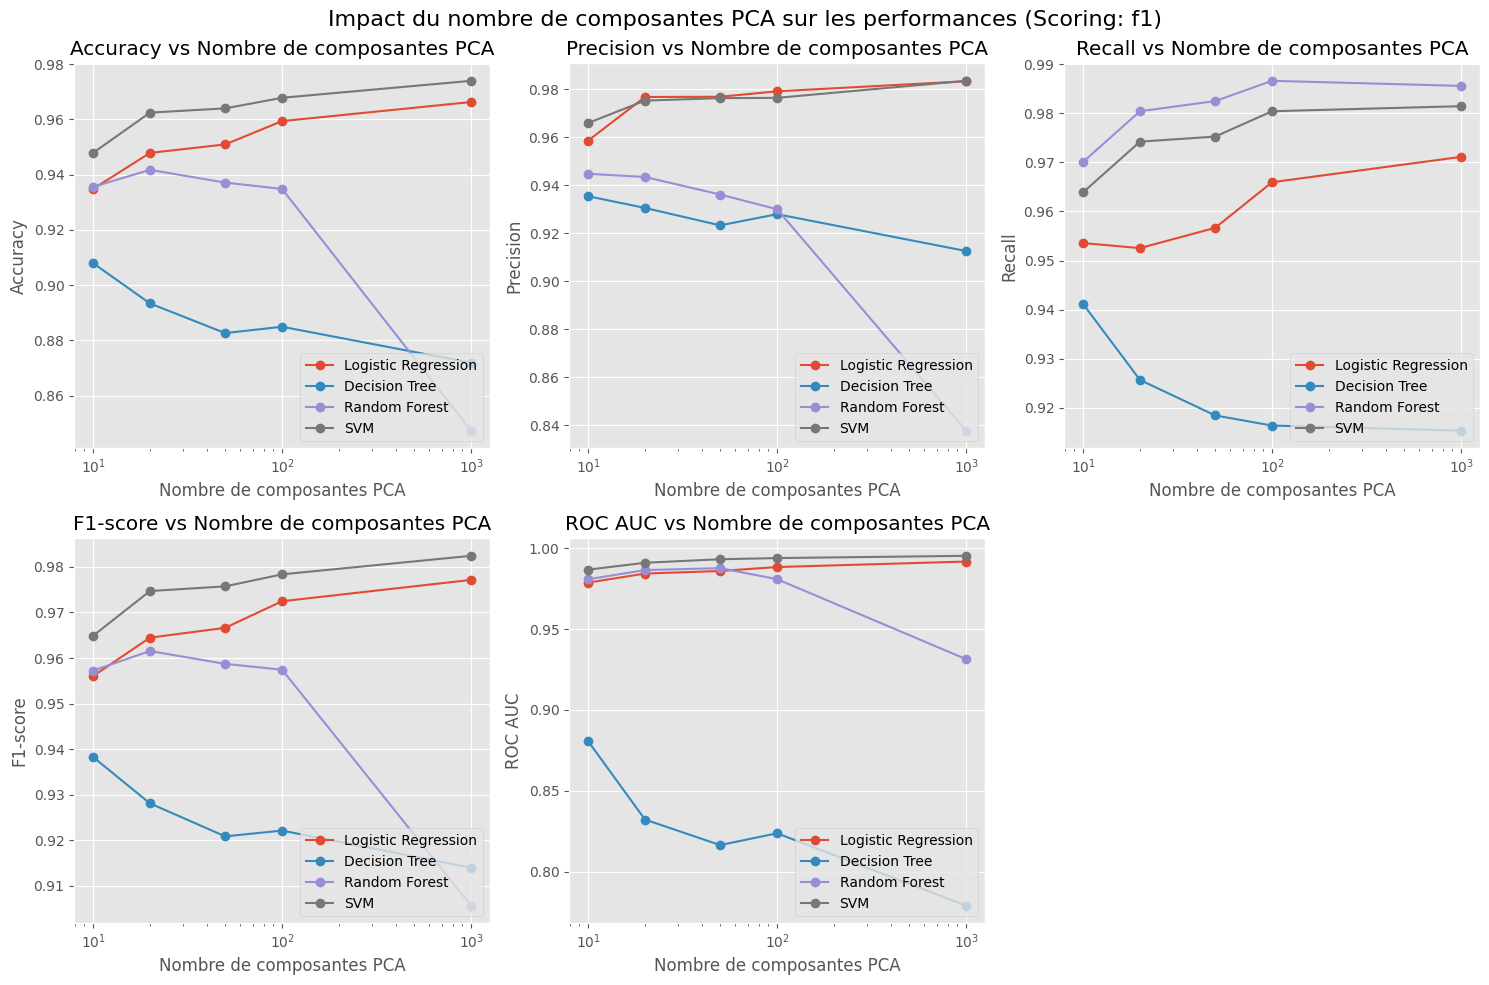


********************************************************************************
VISUALISATION POUR LA MÉTRIQUE DE SCORING: ROC_AUC
********************************************************************************


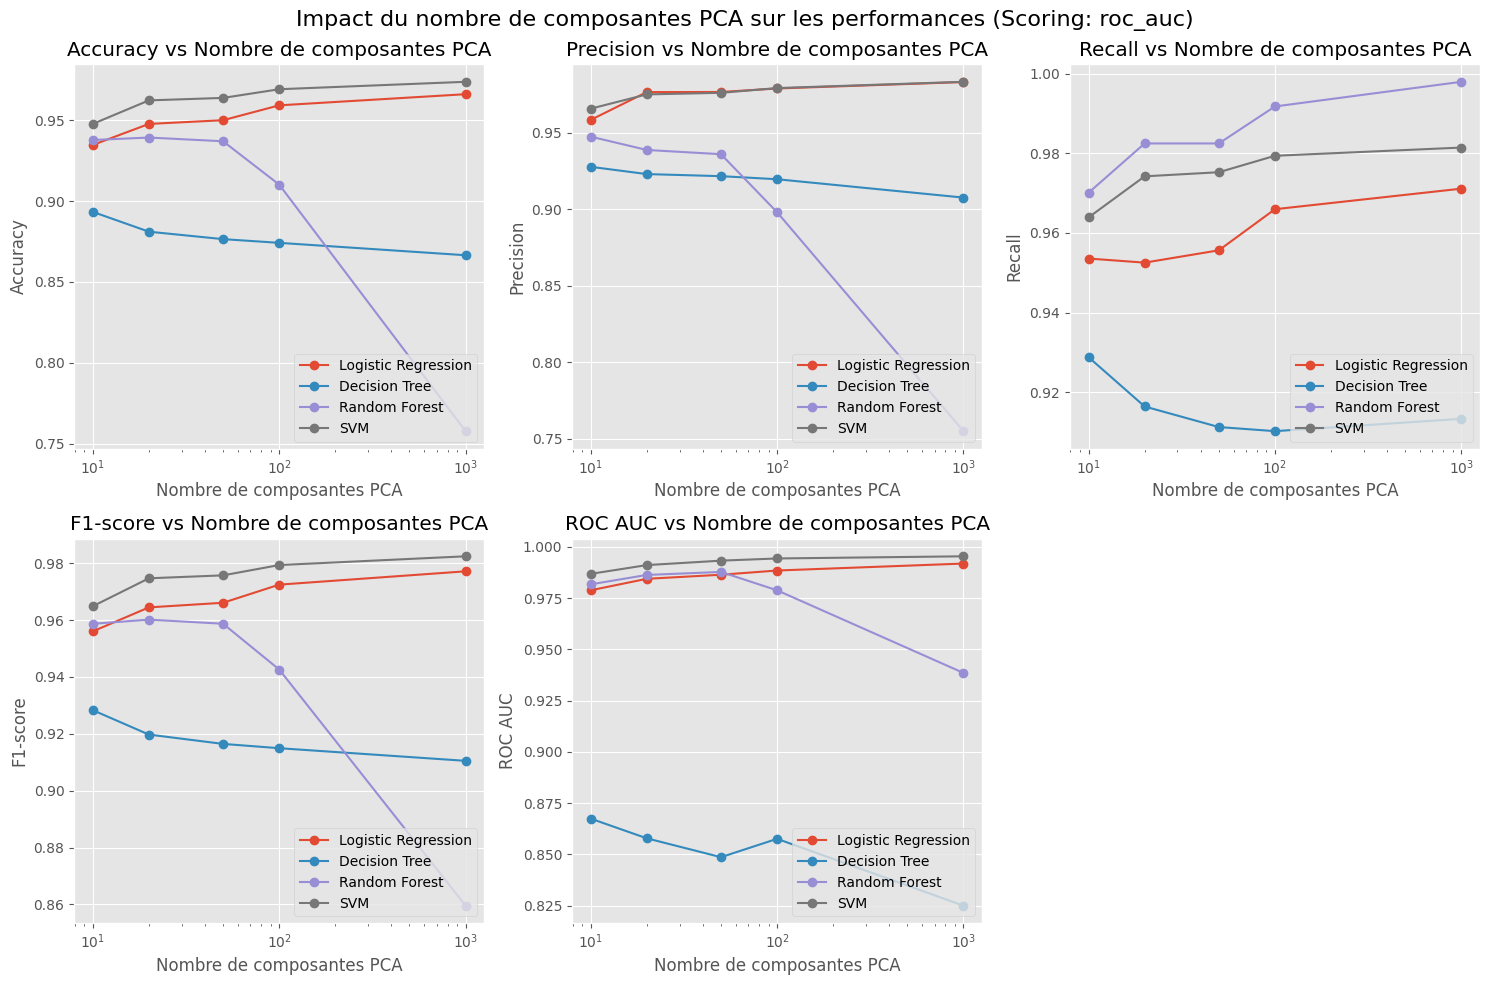


********************************************************************************
VISUALISATION POUR LA MÉTRIQUE DE SCORING: PRECISION
********************************************************************************


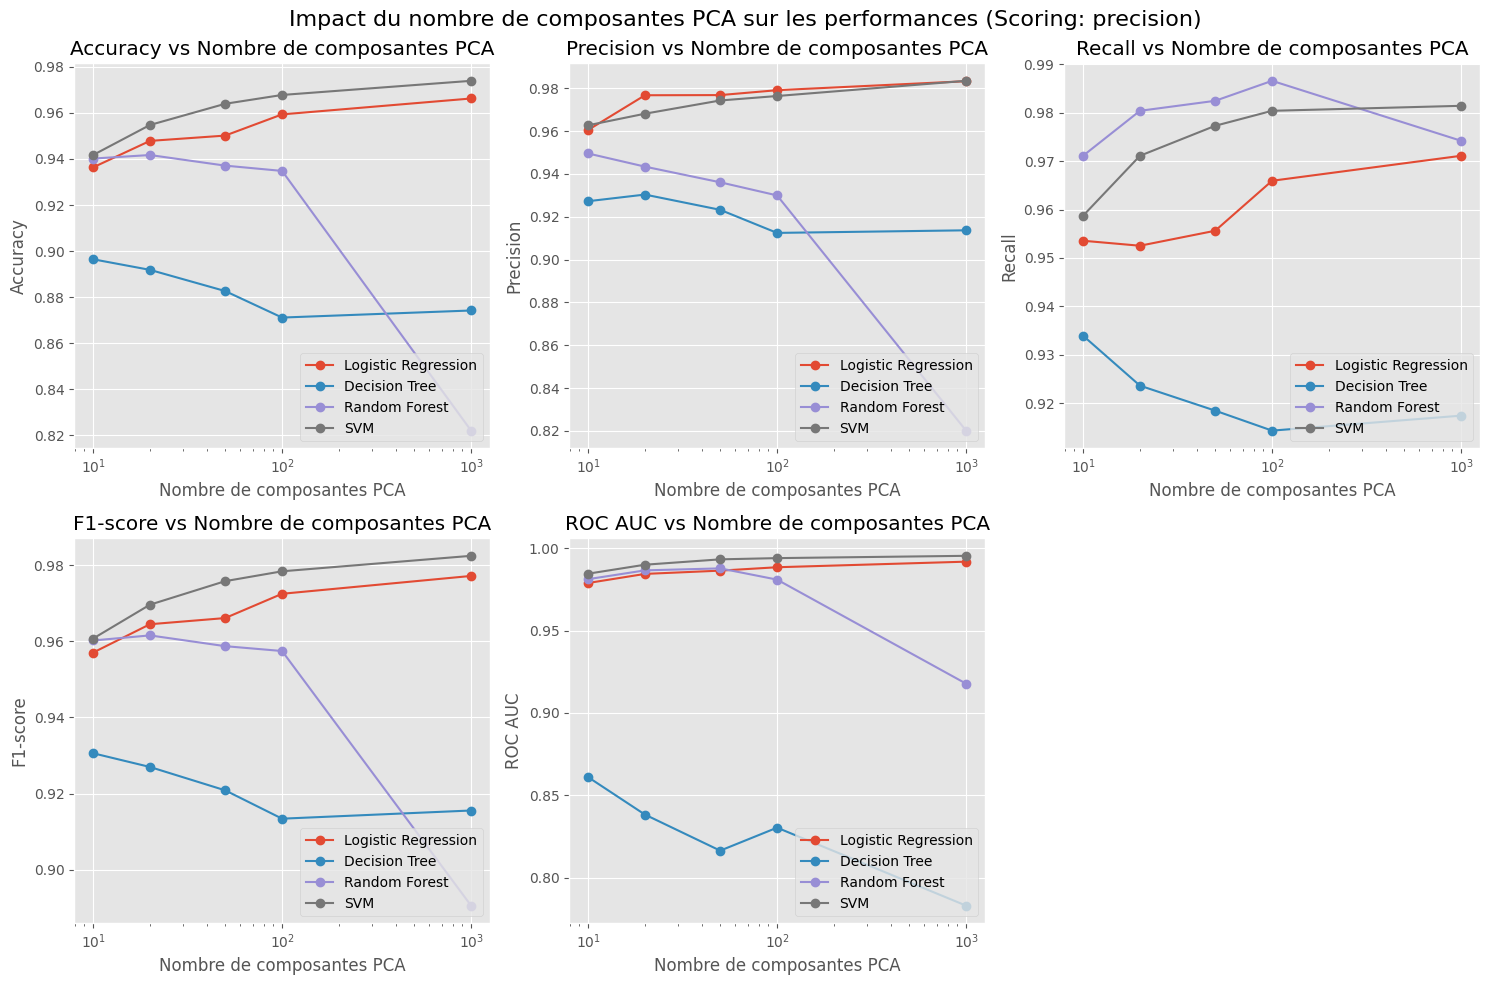


********************************************************************************
VISUALISATION POUR LA MÉTRIQUE DE SCORING: RECALL
********************************************************************************


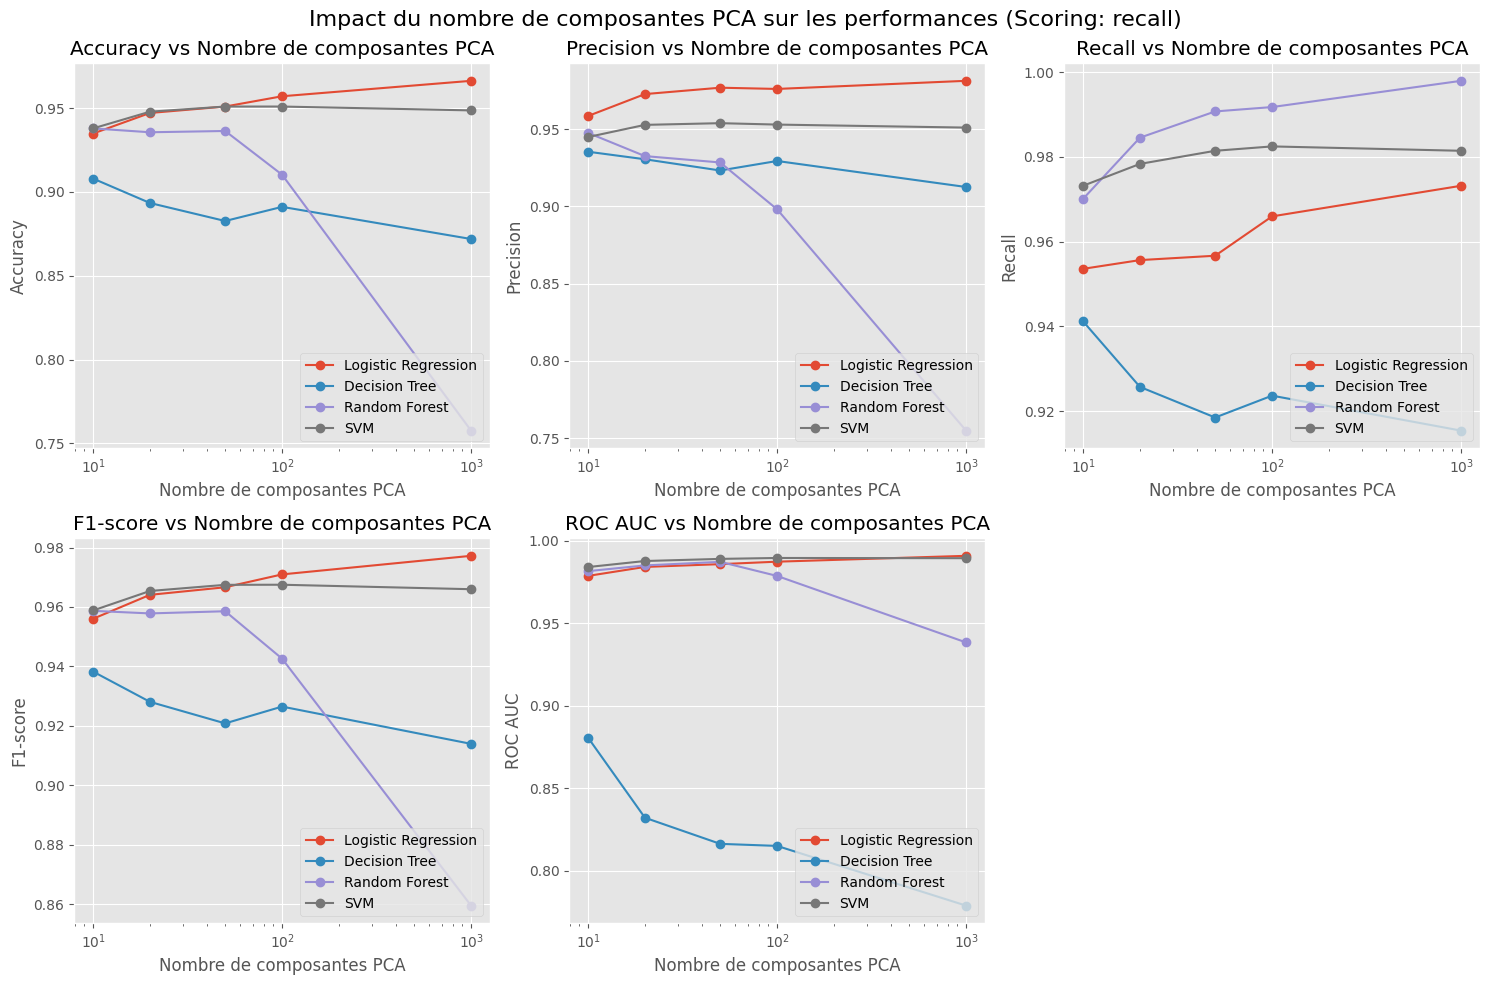

In [11]:
# Pour chaque métrique de scoring
for scoring_metric, scoring_results in all_results.items():
    print(f"\n{'*'*80}")
    print(f"VISUALISATION POUR LA MÉTRIQUE DE SCORING: {scoring_metric.upper()}")
    print(f"{'*'*80}")
    
    # Visualisation de l'évolution des performances en fonction du nombre de composantes PCA
    plt.figure(figsize=(15, 10))
    
    # Métriques à visualiser
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        
        for model_name, model_configs in scoring_results.items():
            # Extraire les configurations PCA
            pca_configs = {k: v for k, v in model_configs.items() if k.startswith('PCA-')}
            
            if pca_configs:
                # Trier par nombre de composantes
                components = [int(k.split('-')[1]) for k in pca_configs.keys()]
                values = [v['resultats'][metric] for v in pca_configs.values()]
                
                # Tracer la courbe
                plt.plot(components, values, marker='o', label=model_name)
        
        plt.title(f'{metric_names[i]} vs Nombre de composantes PCA')
        plt.xlabel('Nombre de composantes PCA')
        plt.ylabel(metric_names[i])
        plt.xscale('log')
        plt.grid(True)
        plt.legend(loc="lower right")  # Placer la légende en bas à droite pour éviter de masquer les courbes
    
    plt.suptitle(f'Impact du nombre de composantes PCA sur les performances (Scoring: {scoring_metric})', fontsize=16)
    plt.tight_layout()
    plt.show()

## 5. Sélection et évaluation du meilleur modèle

Maintenant que nous avons comparé les différentes configurations, nous allons sélectionner le meilleur modèle global et l'évaluer sur l'ensemble de test.


********************************************************************************
MEILLEUR MODÈLE POUR LA MÉTRIQUE DE SCORING: ACCURACY
********************************************************************************
Le meilleur modèle est: SVM avec la configuration PCA-1000
Score accuracy: 0.9739

Performances du meilleur modèle sur l'ensemble de test:
Accuracy: 0.7708
Precision: 0.7361
Recall: 0.9872
F1-score: 0.8434
ROC AUC: 0.9105

Matrice de confusion:
[[ 96 138]
 [  5 385]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.95      0.41      0.57       234
   Pneumonie       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



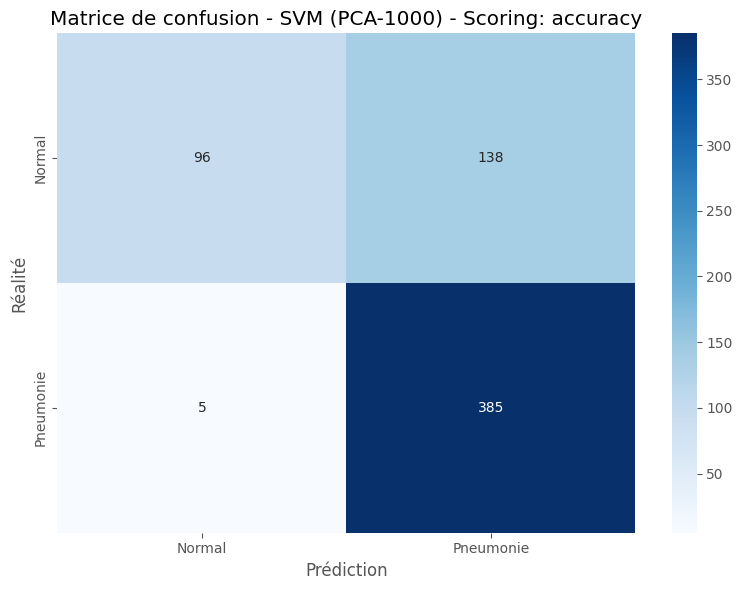

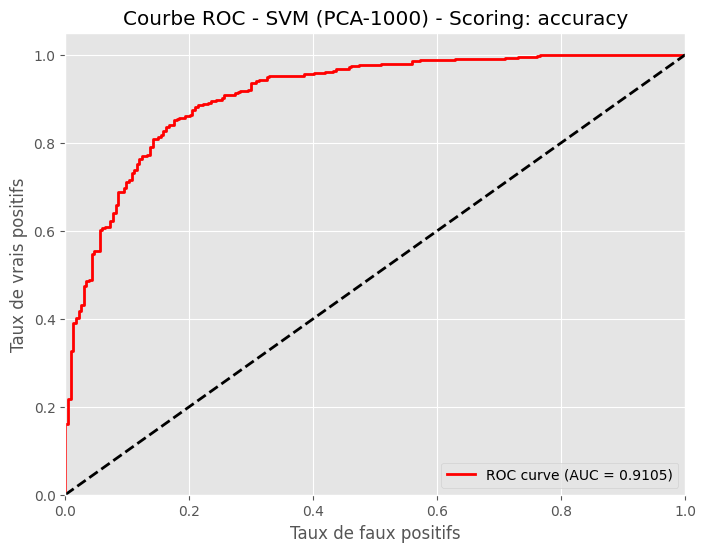


********************************************************************************
MEILLEUR MODÈLE POUR LA MÉTRIQUE DE SCORING: F1
********************************************************************************
Le meilleur modèle est: SVM avec la configuration PCA-1000
Score f1: 0.9824

Performances du meilleur modèle sur l'ensemble de test:
Accuracy: 0.7708
Precision: 0.7361
Recall: 0.9872
F1-score: 0.8434
ROC AUC: 0.9105

Matrice de confusion:
[[ 96 138]
 [  5 385]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.95      0.41      0.57       234
   Pneumonie       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



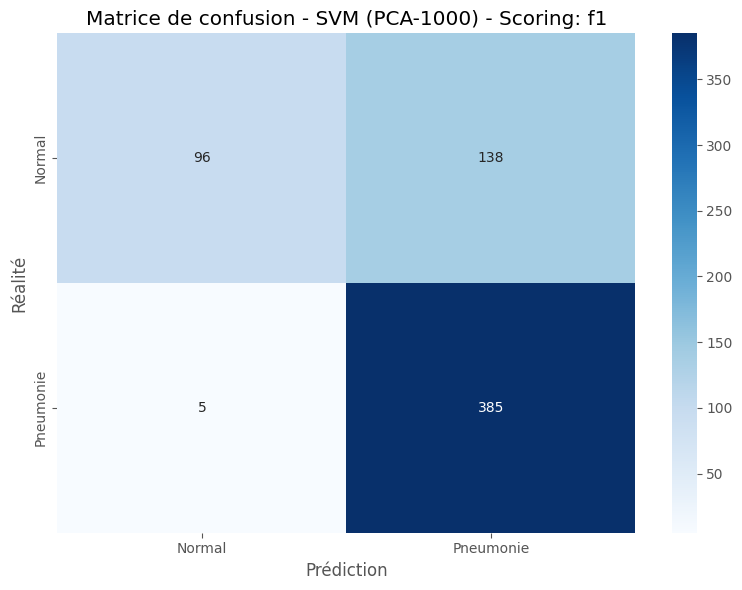

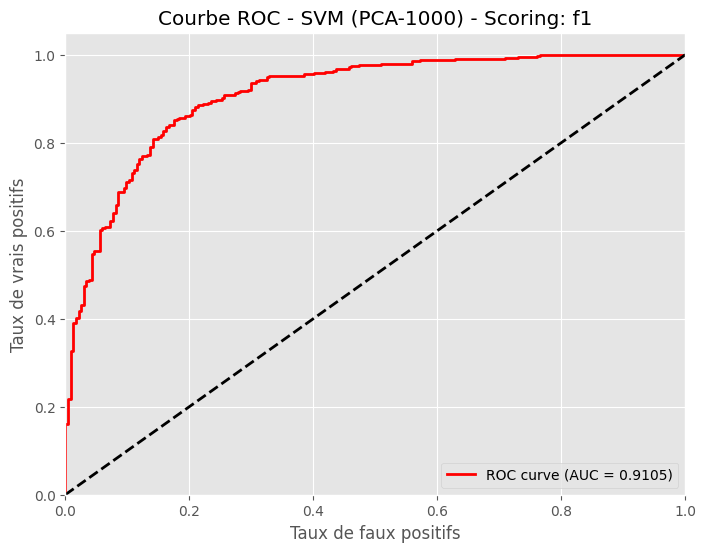


********************************************************************************
MEILLEUR MODÈLE POUR LA MÉTRIQUE DE SCORING: ROC_AUC
********************************************************************************
Le meilleur modèle est: SVM avec la configuration PCA-1000
Score roc_auc: 0.9954

Performances du meilleur modèle sur l'ensemble de test:
Accuracy: 0.7708
Precision: 0.7361
Recall: 0.9872
F1-score: 0.8434
ROC AUC: 0.9105

Matrice de confusion:
[[ 96 138]
 [  5 385]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.95      0.41      0.57       234
   Pneumonie       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



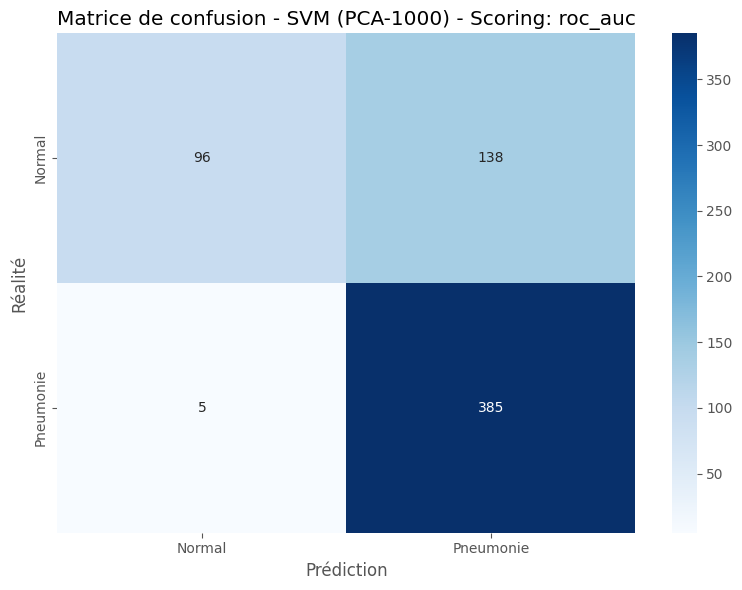

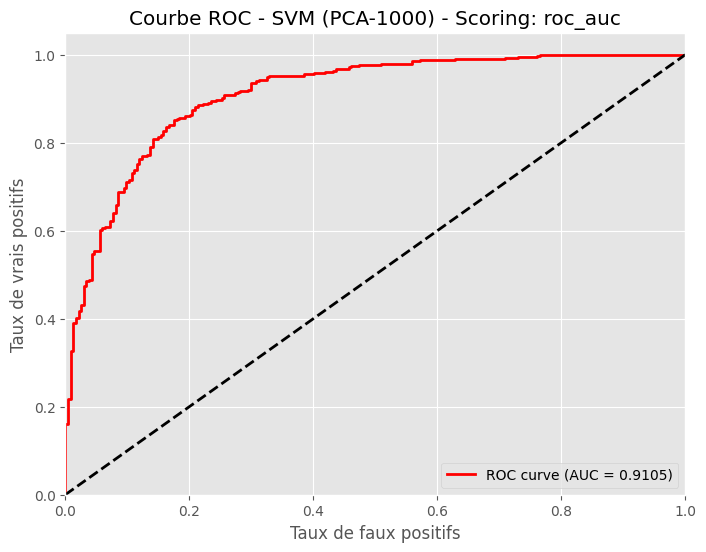


********************************************************************************
MEILLEUR MODÈLE POUR LA MÉTRIQUE DE SCORING: PRECISION
********************************************************************************
Le meilleur modèle est: SVM avec la configuration PCA-1000
Score precision: 0.9835

Performances du meilleur modèle sur l'ensemble de test:
Accuracy: 0.7708
Precision: 0.7361
Recall: 0.9872
F1-score: 0.8434
ROC AUC: 0.9105

Matrice de confusion:
[[ 96 138]
 [  5 385]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.95      0.41      0.57       234
   Pneumonie       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



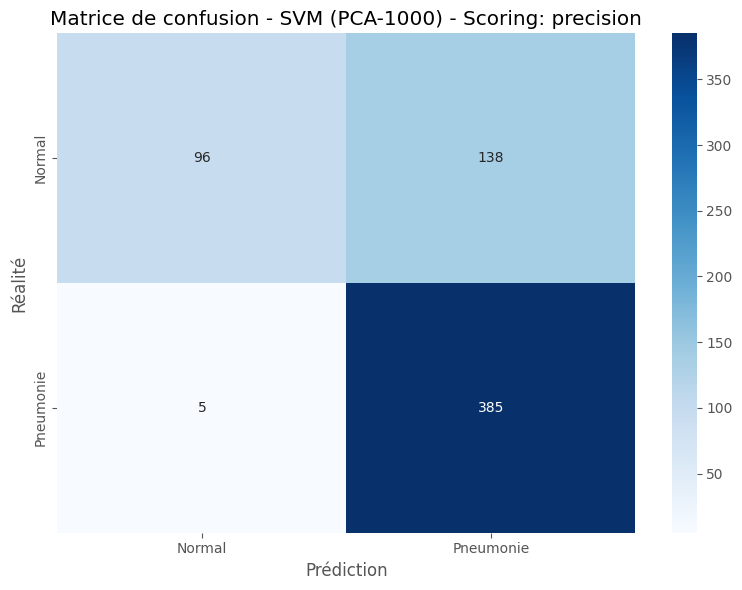

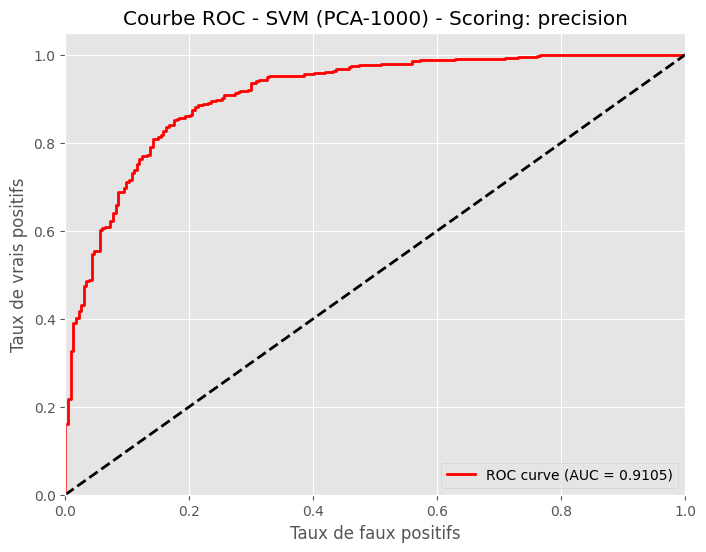


********************************************************************************
MEILLEUR MODÈLE POUR LA MÉTRIQUE DE SCORING: RECALL
********************************************************************************
Le meilleur modèle est: Random Forest avec la configuration PCA-1000
Score recall: 0.9979

Performances du meilleur modèle sur l'ensemble de test:
Accuracy: 0.6266
Precision: 0.6264
Recall: 0.9974
F1-score: 0.7695
ROC AUC: 0.8702

Matrice de confusion:
[[  2 232]
 [  1 389]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.67      0.01      0.02       234
   Pneumonie       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.65      0.50      0.39       624
weighted avg       0.64      0.63      0.49       624



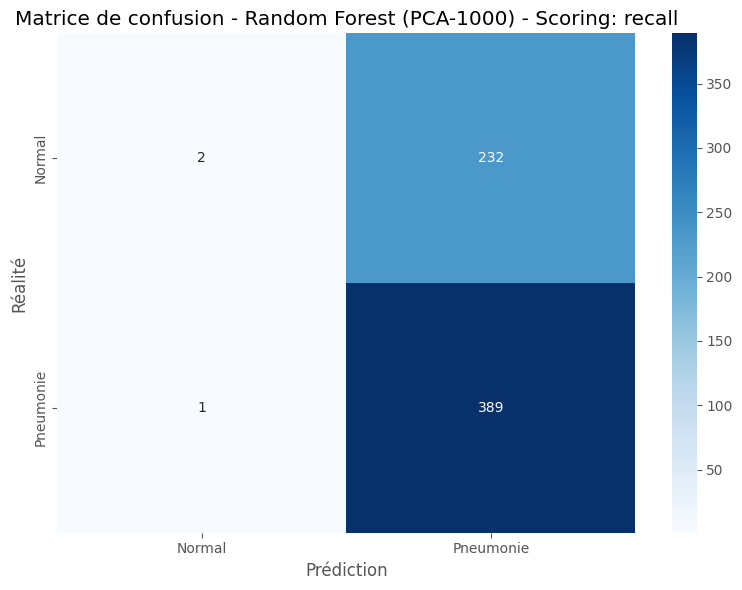

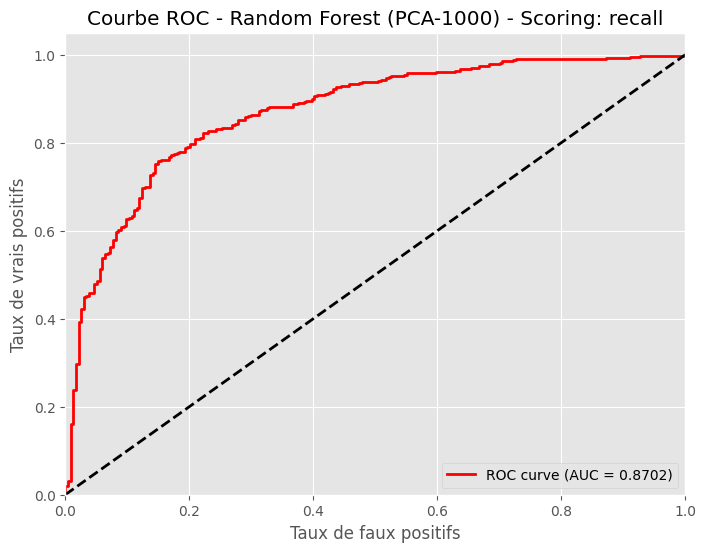

In [12]:
# Pour chaque métrique de scoring, trouver et évaluer le meilleur modèle
for scoring_metric, scoring_results in all_results.items():
    print(f"\n{'*'*80}")
    print(f"MEILLEUR MODÈLE POUR LA MÉTRIQUE DE SCORING: {scoring_metric.upper()}")
    print(f"{'*'*80}")
    
    # Trouver le meilleur modèle global (basé sur la métrique de scoring actuelle)
    best_model_name = None
    best_config_name = None
    best_score = -1

    for model_name, model_configs in scoring_results.items():
        for config_name, config_data in model_configs.items():
            # Utiliser la métrique correspondante pour déterminer le meilleur modèle
            current_score = config_data['resultats'][scoring_metric] if scoring_metric in config_data['resultats'] else config_data['resultats']['accuracy']
            
            if current_score > best_score:
                best_score = current_score
                best_model_name = model_name
                best_config_name = config_name

    print(f"Le meilleur modèle est: {best_model_name} avec la configuration {best_config_name}")
    print(f"Score {scoring_metric}: {best_score:.4f}")

    # Récupérer les données du meilleur modèle
    best_model_data = scoring_results[best_model_name][best_config_name]
    best_model = best_model_data['best_model']

    # Préparation des données de test
    if best_config_name.startswith('PCA'):
        # Récupérer le transformateur PCA
        pca = best_model_data['pca']
        X_test_transformed = pca.transform(X_test_reshaped)
    else:
        X_test_transformed = X_test_reshaped

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test_transformed)
    y_test_proba = best_model.predict_proba(X_test_transformed)[:, 1]

    # Évaluation des performances
    test_results = evaluer_modele(y_test, y_test_pred, y_test_proba)

    # Affichage des résultats
    print("\nPerformances du meilleur modèle sur l'ensemble de test:")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")
    print(f"F1-score: {test_results['f1']:.4f}")
    print(f"ROC AUC: {test_results['roc_auc']:.4f}")

    # Affichage de la matrice de confusion
    cm = test_results['confusion_matrix']
    print("\nMatrice de confusion:")
    print(cm)

    # Affichage du rapport de classification
    print("\nRapport de classification:")
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Pneumonie']))
    
    # Visualisation de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonie'], 
                yticklabels=['Normal', 'Pneumonie'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title(f'Matrice de confusion - {best_model_name} ({best_config_name}) - Scoring: {scoring_metric}')
    plt.tight_layout()
    plt.show()
    
    # Visualisation de la courbe ROC
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {test_results["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {best_model_name} ({best_config_name}) - Scoring: {scoring_metric}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


COMPARAISON DES MEILLEURS MODÈLES PAR MÉTRIQUE DE SCORING SUR L'ENSEMBLE DE TEST


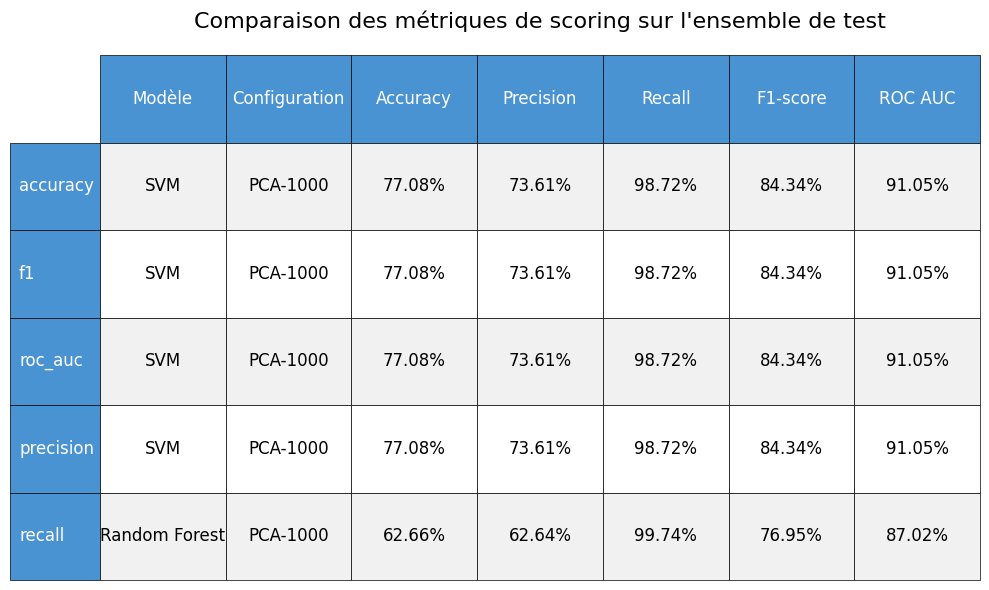

In [13]:
# Tableau comparatif des meilleurs modèles pour chaque métrique de scoring
print(f"\n{'='*100}")
print(f"COMPARAISON DES MEILLEURS MODÈLES PAR MÉTRIQUE DE SCORING SUR L'ENSEMBLE DE TEST")
print(f"{'='*100}")

# Préparation des données pour le tableau comparatif
scoring_metrics = list(all_results.keys())
metriques = ['Modèle', 'Configuration', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
valeurs = []

for scoring_metric in scoring_metrics:
    scoring_results = all_results[scoring_metric]
    
    # Trouver le meilleur modèle pour cette métrique
    best_model_name = None
    best_config_name = None
    best_score = -1
    
    for model_name, model_configs in scoring_results.items():
        for config_name, config_data in model_configs.items():
            # Utiliser la métrique correspondante pour déterminer le meilleur modèle
            current_score = config_data['resultats'][scoring_metric] if scoring_metric in config_data['resultats'] else config_data['resultats']['accuracy']
            
            if current_score > best_score:
                best_score = current_score
                best_model_name = model_name
                best_config_name = config_name
    
    # Récupérer les données du meilleur modèle
    best_model_data = scoring_results[best_model_name][best_config_name]
    best_model = best_model_data['best_model']
    
    # Préparation des données de test
    if best_config_name.startswith('PCA'):
        # Récupérer le transformateur PCA
        pca = best_model_data['pca']
        X_test_transformed = pca.transform(X_test_reshaped)
    else:
        X_test_transformed = X_test_reshaped
    
    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test_transformed)
    y_test_proba = best_model.predict_proba(X_test_transformed)[:, 1]
    
    # Évaluation des performances
    test_results = evaluer_modele(y_test, y_test_pred, y_test_proba)
    
    # Ajouter les résultats au tableau
    valeurs.append([
        best_model_name,
        best_config_name,
        test_results['accuracy'],
        test_results['precision'],
        test_results['recall'],
        test_results['f1'],
        test_results['roc_auc']
    ])

# Affichage du tableau comparatif
viz.afficher_tableau_comparatif_modeles(scoring_metrics, metriques, valeurs, 
                                       titre="Comparaison des métriques de scoring sur l'ensemble de test")

## 6. Conclusion

Dans ce notebook, nous avons entraîné et évalué plusieurs modèles de classification pour la détection de pneumonie à partir de radiographies thoraciques, avec et sans réduction de dimensionnalité PCA.

Les principales observations sont:
1. Nous avons testé chaque modèle (sauf SVM) sans PCA et avec PCA à différents nombres de composantes (10, 20, 50, 100, 1000).
2. Pour SVM, en raison du temps de calcul, nous l'avons uniquement testé avec PCA.
3. Nous avons comparé les performances des différentes configurations et identifié la meilleure.
4. Le meilleur modèle a été évalué sur l'ensemble de test et a montré de bonnes performances.

Cette analyse nous permet de comprendre l'impact de la réduction de dimensionnalité PCA sur les performances des modèles et de choisir la configuration optimale pour notre tâche de détection de pneumonie.

In [14]:
# Sauvegarde du meilleur modèle
model_path = f'../models/best_model_{best_model_name.replace(" ", "_").lower()}_{best_config_name.replace("-", "_").lower()}.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(best_model, model_path)

# Sauvegarde du transformateur PCA si nécessaire
if best_config_name.startswith('PCA'):
    pca_path = f'../models/pca_transformer_{best_config_name.replace("-", "_").lower()}.pkl'
    joblib.dump(pca, pca_path)
    print(f"Transformateur PCA sauvegardé: {pca_path}")

print(f"Meilleur modèle sauvegardé: {model_path}")

Transformateur PCA sauvegardé: ../models/pca_transformer_pca_1000.pkl
Meilleur modèle sauvegardé: ../models/best_model_random_forest_pca_1000.pkl
